# Analysis of COVID-19 infections data in Italy

## Authors:
> **Jacopo Bartoli**  
> Università degli Studi di Firenze - Scuola di Ingegneria  
> jacopo.bartoli@stud.unifi.it  

> **Jason Ravagli**  
> Università degli Studi di Firenze - Scuola di Ingegneria  
> jason.ravagli@stud.unifi.it

---

## Outline
1. [Introduction](#section_1)
2. [Loading data](#section_2)
3. [Analysis of national data](#section_3)
4. [Analysis of absolute regional data](#section_4)
5. [Analysis of regional data with respect to the population](#section_5)
6. [Geographical analysis using maps](#section_6)
7. [Conclusions](#section_7)

---

## 1. Introduction<a name="section_1"></a>
We are all aware of the situation that the COVID-19 pandemic has caused in Italy during 2020. Starting from March 2020, the Italian Civil Protection (ICP) has begun to gather and make available daily data about contagious (such as the number of new positives, hospitalized infected, deaths, etc..) in our country to inform the population.

In addition to using the usual communication channels, the ICP created a [GitHub repository](https://github.com/pcm-dpc/COVID-19) to publish all the data and make them usable to research purposes. The main contributor to this repository is Umberto Rosini (https://github.com/umbros), an employee of the ICP.

The repository contains various kinds of data regarding the emergency and the infection, but in this notebook we focus on the analysis of two data files:

- https://github.com/pcm-dpc/COVID-19/blob/master/dati-json/dpc-covid19-ita-province.json
- https://github.com/pcm-dpc/COVID-19/blob/master/dati-json/dpc-covid19-ita-regioni.json

They contain the data about contagion day by day since 24th February 2020 and, at the time of writing (21st August 2020), they are updated every day at 18:30.  
The first file contains data divided by province, while the second one contains data divided by region.

### Setup environment
This notebook was realized with Python 3.7.6.

Installing required libraries:

In [234]:
import sys

!$sys.executable -m pip install matplotlib==3.1.3
!$sys.executable -m pip install pandas==1.0.3
!$sys.executable -m pip install seaborn==0.10.1
!$sys.executable -m pip install geopandas==0.8.1
!$sys.executable -m pip install descartes==1.1.0

Importing libraries:

In [235]:
import os
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # To give a prettier style to charts
import geopandas as gpd # To plot maps. Transitive dependency: descartes

# Required to visualize maps in jupyter
%matplotlib inline
# Set Seaborn style for charts
sns.set()

The data used in this notebook can be downloaded from [here](https://github.com/JacopoBartoli/agm_algorithms), and you need to put them in a folder called "data" in the same directory of the nootebook.

## 2. Loading data<a name="section_2"></a>
### Loading data as list of dictionaries

Inspecting the JSON files, we can observe that in each of them data are stored as an array of JSON objects. Therefore, we can load data in a list of Python dictionaries to take a first look at their structure.

In [236]:
with open("data/dpc-covid19-ita-regioni.json") as f:
    list_dict_reg = json.load(f)

In [237]:
with open("data/dpc-covid19-ita-province.json") as f:
    list_dict_prov = json.load(f)

In [238]:
list_dict_reg[0]

{'data': '2020-02-24T18:00:00',
 'stato': 'ITA',
 'codice_regione': 13,
 'denominazione_regione': 'Abruzzo',
 'lat': 42.35122196,
 'long': 13.39843823,
 'ricoverati_con_sintomi': 0,
 'terapia_intensiva': 0,
 'totale_ospedalizzati': 0,
 'isolamento_domiciliare': 0,
 'totale_positivi': 0,
 'variazione_totale_positivi': 0,
 'nuovi_positivi': 0,
 'dimessi_guariti': 0,
 'deceduti': 0,
 'casi_da_sospetto_diagnostico': None,
 'casi_da_screening': None,
 'totale_casi': 0,
 'tamponi': 5,
 'casi_testati': None,
 'note': None}

In [239]:
list_dict_prov[0]

{'data': '2020-02-24T18:00:00',
 'stato': 'ITA',
 'codice_regione': 13,
 'denominazione_regione': 'Abruzzo',
 'codice_provincia': 66,
 'denominazione_provincia': "L'Aquila",
 'sigla_provincia': 'AQ',
 'lat': 42.35122196,
 'long': 13.39843823,
 'totale_casi': 0,
 'note': None}

Each data object contains information about the cases of COVID-19 in a particular day for each region/province.
Data about regions contain exhaustive information about the detected cases, and a full explanation of each data field can be found [here](https://github.com/pcm-dpc/COVID-19/blob/master/dati-andamento-covid19-italia.md).

Add fields explanation:

1. Field 1
2. Field 2


---

### Loading data as Pandas dataframe

In [240]:
df_reg = pd.DataFrame(list_dict_reg)

In [241]:
df_prov = pd.DataFrame(list_dict_prov)

---

Let us take an overview at the regions data.

In [242]:
df_reg.shape

(3738, 21)

In [243]:
df_reg.dtypes

data                             object
stato                            object
codice_regione                    int64
denominazione_regione            object
lat                             float64
long                            float64
ricoverati_con_sintomi            int64
terapia_intensiva                 int64
totale_ospedalizzati              int64
isolamento_domiciliare            int64
totale_positivi                   int64
variazione_totale_positivi        int64
nuovi_positivi                    int64
dimessi_guariti                   int64
deceduti                          int64
casi_da_sospetto_diagnostico    float64
casi_da_screening               float64
totale_casi                       int64
tamponi                           int64
casi_testati                    float64
note                             object
dtype: object

In [244]:
df_reg.head()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,...,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati,note
0,2020-02-24T18:00:00,ITA,13,Abruzzo,42.351222,13.398438,0,0,0,0,...,0,0,0,0,NaN,NaN,0,5,NaN,None
1,2020-02-24T18:00:00,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,...,0,0,0,0,NaN,NaN,0,0,NaN,None
2,2020-02-24T18:00:00,ITA,18,Calabria,38.905976,16.594402,0,0,0,0,...,0,0,0,0,NaN,NaN,0,1,NaN,None
3,2020-02-24T18:00:00,ITA,15,Campania,40.839566,14.250850,0,0,0,0,...,0,0,0,0,NaN,NaN,0,10,NaN,None
4,2020-02-24T18:00:00,ITA,8,Emilia-Romagna,44.494367,11.341721,10,2,12,6,...,0,18,0,0,NaN,NaN,18,148,NaN,None


In [245]:
df_reg.describe()

,codice_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati
count,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,1176.000000,1176.000000,3738.000000,3.738000e+03,2583.000000
mean,11.857143,43.046293,12.225955,444.334136,50.146602,494.480738,1557.240770,2051.721509,4.050027,68.313002,5435.201980,1208.643125,10614.001701,1097.881803,8695.566613,1.607540e+05,137174.008904
std,6.274638,2.489114,2.659303,1323.771538,140.420552,1459.140050,3563.133122,4776.091041,185.709468,199.965627,11458.321257,2992.315037,19311.460927,1798.906944,17203.130676,2.438840e+05,145445.090715
min,1.000000,38.115697,7.320149,0.000000,0.000000,0.000000,0.000000,0.000000,-5339.000000,-229.000000,0.000000,0.000000,400.000000,0.000000,0.000000,0.000000e+00,3482.000000
25%,7.000000,41.125596,11.121231,9.000000,0.000000,10.000000,72.000000,87.250000,-12.000000,1.000000,245.250000,64.000000,1433.000000,17.000000,1100.000000,1.589075e+04,43673.500000
50%,12.000000,43.616760,12.388247,56.000000,5.000000,63.000000,320.000000,398.000000,0.000000,9.000000,1351.000000,291.000000,3348.000000,191.500000,3154.500000,7.786100e+04,83144.000000
75%,17.000000,45.434905,13.768136,255.000000,36.000000,294.000000,1313.750000,1648.250000,14.000000,48.000000,4404.000000,870.000000,8614.500000,1579.000000,7549.500000,1.888848e+05,182034.500000
max,22.000000,46.499335,16.867367,12077.000000,1381.000000,13328.000000,30382.000000,37307.000000,1950.000000,3251.000000,75398.000000,16844.000000,90487.000000,7485.000000,97564.000000,1.432476e+06,855372.000000


---

Now let us do the same thing for the province data.

In [246]:
df_prov.shape

(23960, 11)

In [247]:
df_prov.dtypes

data                        object
stato                       object
codice_regione               int64
denominazione_regione       object
codice_provincia             int64
denominazione_provincia     object
sigla_provincia             object
lat                        float64
long                       float64
totale_casi                  int64
note                        object
dtype: object

In [248]:
df_prov.head()

,data,stato,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,totale_casi,note
0,2020-02-24T18:00:00,ITA,13,Abruzzo,66,L'Aquila,AQ,42.351222,13.398438,0,None
1,2020-02-24T18:00:00,ITA,13,Abruzzo,67,Teramo,TE,42.658918,13.704400,0,None
2,2020-02-24T18:00:00,ITA,13,Abruzzo,68,Pescara,PE,42.464584,14.213648,0,None
3,2020-02-24T18:00:00,ITA,13,Abruzzo,69,Chieti,CH,42.351032,14.167546,0,None
4,2020-02-24T18:00:00,ITA,13,Abruzzo,979,In fase di definizione/aggiornamento,None,NaN,NaN,0,None


In [249]:
df_prov.describe()

,codice_regione,codice_provincia,lat,long,totale_casi
count,23960.000000,23960.000000,19046.000000,19046.000000,23960.000000
mean,10.499499,240.971536,42.908522,12.096599,1356.585935
std,6.053899,369.370866,2.631578,2.660616,2748.219583
min,1.000000,1.000000,36.925092,7.320149,0.000000
25%,5.000000,34.000000,40.914047,9.828190,59.000000
50%,9.000000,68.000000,43.715532,12.104734,424.000000
75%,16.000000,101.000000,45.185093,14.167546,1367.000000
max,22.000000,999.000000,46.499335,18.171897,25297.000000


### Cleaning and preparing data

From the above tables we can observe that there are some useless data in both dataframes.
First of all we can drop the column `stato` from both, since the data all refer to the Italy (we can verify that `ITA` is the unique value).

In [250]:
df_reg['stato'].unique(), df_prov['stato'].unique()

(array(['ITA'], dtype=object), array(['ITA'], dtype=object))

In [251]:
df_reg.drop(columns=["stato"], inplace=True)
df_prov.drop(columns=["stato"], inplace=True)

Also the field `note` can be removed from the regions dataframe since it contains not useful plain textual data.

In [252]:
df_reg["note"].unique()

array([None, 'pd-IT-0002', 'pd-IT-0004', 'nd-IT-0001', 'nd-IT-0003',
       'nd-IT-0005', 'nd-IT-0008', 'nd-IT-0013', 'nd-IT-0011',
       'pd-IT-0006', 'pd-IT-0008', 'pd-IT-0010', 'dc-IT-0002',
       'dc-IT-0004', 'dc-IT-0006', 'pd-IT-0012', 'pd-IT-0014',
       'pd-IT-0016', 'dc-IT-0008', 'dc-IT-0010', 'dc-IT-0012',
       'dc-IT-0014', 'dc-IT-0016', 'dc-IT-0018', 'dc-IT-0020',
       'dc-IT-0022', 'dc-IT-0024', 'dc-IT-0026', 'dc-IT-0028',
       'dc-IT-0030', 'pd-IT-0018', 'dc-IT-0032', 'pd-IT-0020',
       'dc-IT-0034', 'dc-IT-0036', 'nd-IT-0015', 'pd-IT-0022',
       'dc-IT-0037', 'dc-IT-0038', 'dc-IT-0040', 'dc-IT-0042',
       'dc-IT-0046', 'dc-IT-0044', 'dc-IT-0048', 'dc-IT-0050',
       'dc-IT-0052', 'dc-IT-0054', 'dc-IT-0056', 'dc-EN-0058',
       'dc-IT-0062', 'dc-IT-0060', 'dc-IT-0064', 'dc-IT-0066',
       'dc-IT-0068', 'dc-IT-0070',
       'n.3 decessi precedentemente segnalati, da una revisione non risultano classificabili come COVID-19 positivi',
       'NEI CASI POSIT

In [253]:
df_prov["note"].unique()

array([None, 'pd-IT-0001', 'nd-IT-0007', 'nd-IT-0010', 'dc-IT-0001',
       'di cui 24 Stato estero', 'di cui 66 stato estero',
       "NEL TOTALE CASI POSITIVI SONO COMPRESI ULTERIORI N. 2 SOGGETTI RISULTATI POSITIVI PER ATTIVITA' DI SCREENING, ASINTOMATICI ED  IN ISOLAMENTO DOMICILIARE, NON RESIDENTI E PROVENIENTI DA STATO ESTERO.  ",
       "NEL TOTALE CASI POSITIVI SONO COMPRESI N. 2 SOGGETTI RISULTATI POSITIVI PER ATTIVITA' DI SCREENING, ASINTOMATICI ED  IN ISOLAMENTO DOMICILIARE, NON RESIDENTI E PROVENIENTI DA STATO ESTERO.  ",
       ' ',
       "NEL TOTALE CASI POSITIVI SONO COMPRESI N. 2 SOGGETTI RISULTATI POSITIVI PER ATTIVITA' DI SCREENING, PROVENIENTI DA STATO ESTERO.  ",
       'N. 1 NUOVO CASO POSITIVO DA SCREENING DI SOGGETTO RESIDENTE IN BASILICATA MA PROVENIENTE DA STATO ESTERO OVE SOGGIORNA PER MOTIVI DI LAVORO (KAZAKISTAN)',
       "NEL TOTALE CASI POSITIVI DA ATTIVITA' DI SCREENING SONO COMPRESI N. 2 SOGGETTI RISULTATI POSITIVI, PROVENIENTI DA STATO ESTERO (MOLDAVIA

In [254]:
df_reg.drop(columns=["note"], inplace=True)
df_prov.drop(columns=["note"], inplace=True)

Looking at the column types, we can see that the data under the columns `data` are stored as `object` in both dataframes. It is more appropriate to use the pandas `Timestamp` type, to facilitate queries.  
According to the documentation and to the size of data, for each day and region (for each day and province for the provinces dataframe) there is a unique entry, so for simplicity we can keep only the date without the time normalizing the column.

In [255]:
df_reg["data"] = pd.DatetimeIndex(df_reg["data"]).normalize()
df_prov["data"] = pd.DatetimeIndex(df_prov["data"]).normalize()

In the province dataframe we can see that there are data not referring to specific provinces (`sigla_provincia`, `lat`, `long` not valued). According to the documentation these data contains information about infected not yet assigned to any province or region.  
Since we are interested into provinces data only we can discard these rows:

In [256]:
df_prov = df_prov[df_prov["lat"].notnull()]
df_prov.head()

,data,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,totale_casi
0,2020-02-24,13,Abruzzo,66,L'Aquila,AQ,42.351222,13.398438,0
1,2020-02-24,13,Abruzzo,67,Teramo,TE,42.658918,13.704400,0
2,2020-02-24,13,Abruzzo,68,Pescara,PE,42.464584,14.213648,0
3,2020-02-24,13,Abruzzo,69,Chieti,CH,42.351032,14.167546,0
5,2020-02-24,17,Basilicata,76,Potenza,PZ,40.639471,15.805148,0


Still in provinces data we can found an error in data referring to Napoli: `sigla_provincia` is not valued.

In [257]:
df_prov[df_prov["sigla_provincia"].isna()].head()

,data,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,totale_casi
16,2020-02-24,15,Campania,63,Napoli,None,40.839566,14.25085,0
144,2020-02-25,15,Campania,63,Napoli,None,40.839566,14.25085,0
272,2020-02-26,15,Campania,63,Napoli,None,40.839566,14.25085,0
400,2020-02-27,15,Campania,63,Napoli,None,40.839566,14.25085,3
528,2020-02-28,15,Campania,63,Napoli,None,40.839566,14.25085,4


We fix this by replacing the missing values with *'NA'*:

In [258]:
df_prov.loc[df_prov["denominazione_provincia"] == "Napoli", "sigla_provincia"] = "NA"
df_prov[df_prov["denominazione_provincia"] == "Napoli"].head()

,data,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,totale_casi
16,2020-02-24,15,Campania,63,Napoli,NA,40.839566,14.25085,0
144,2020-02-25,15,Campania,63,Napoli,NA,40.839566,14.25085,0
272,2020-02-26,15,Campania,63,Napoli,NA,40.839566,14.25085,0
400,2020-02-27,15,Campania,63,Napoli,NA,40.839566,14.25085,3
528,2020-02-28,15,Campania,63,Napoli,NA,40.839566,14.25085,4


Finally, it would be useful for the next analysis to modify the indexes to use a multi-index with the date and regions for the regions data and a multi-index with the date and provinces for the provinces ones.

In [259]:
df_reg.set_index(["data", "denominazione_regione"], inplace=True)
df_prov.set_index(["data", "sigla_provincia"], inplace=True)

Let us look at the obtained data:

In [260]:
df_reg

codice_regione        lat       long  \
data       denominazione_regione                                         
2020-02-24 Abruzzo                            13  42.351222  13.398438   
           Basilicata                         17  40.639471  15.805148   
           Calabria                           18  38.905976  16.594402   
           Campania                           15  40.839566  14.250850   
           Emilia-Romagna                      8  44.494367  11.341721   
...                                          ...        ...        ...   
2020-08-19 Sicilia                            19  38.115697  13.362357   
           Toscana                             9  43.769231  11.255889   
           Umbria                             10  43.106758  12.388247   
           Valle d'Aosta                       2  45.737503   7.320149   
           Veneto                              5  45.434905  12.338452   

                                  ricoverati_con_sintomi  terapia_intensiva  \
data       denominazione_regione                                              
2020-02-24 Abruzzo                                     0                  0   
           Basilicata                                  0                  0   
           Calabria                                    0                  0   
           Campania                                    0                  0   
           Emilia-Romagna                             10                  2   
...                                                  ...                ...   
2020-08-19 Sicilia                                    53                  8   
           Toscana                                    20                  5   
           Umbria                                      9                  2   
           Valle d'Aosta                               1                  0   
           Veneto                                     39                  6   

                                  totale_ospedalizzati  \
data       denominazione_regione                         
2020-02-24 Abruzzo                                   0   
           Basilicata                                0   
           Calabria                                  0   
           Campania                                  0   
           Emilia-Romagna                           12   
...                                                ...   
2020-08-19 Sicilia                                  61   
           Toscana                                  25   
           Umbria                                   11   
           Valle d'Aosta                             1   
           Veneto                                   45   

                                  isolamento_domiciliare  totale_positivi  \
data       denominazione_regione                                            
2020-02-24 Abruzzo                                     0                0   
           Basilicata                                  0                0   
           Calabria                                    0                0   
           Campania                                    0                0   
           Emilia-Romagna                              6               18   
...                                                  ...              ...   
2020-08-19 Sicilia                                   705              766   
           Toscana                                   721              746   
           Umbria                                     84               95   
           Valle d'Aosta                               9               10   
           Veneto                                   1616             1661   

                                  variazione_totale_positivi  nuovi_positivi  \
data       denominazione_regione                                               
2020-02-24 Abruzzo                                         0               0   
           Basilicata                         

In [261]:
df_prov

codice_regione denominazione_regione  \
data       sigla_provincia                                         
2020-02-24 AQ                           13               Abruzzo   
           TE                           13               Abruzzo   
           PE                           13               Abruzzo   
           CH                           13               Abruzzo   
           PZ                           17            Basilicata   
...                                    ...                   ...   
2020-08-19 BL                            5                Veneto   
           TV                            5                Veneto   
           VE                            5                Veneto   
           PD                            5                Veneto   
           RO                            5                Veneto   

                            codice_provincia denominazione_provincia  \
data       sigla_provincia                                             
2020-02-24 AQ                             66                L'Aquila   
           TE                             67                  Teramo   
           PE                             68                 Pescara   
           CH                             69                  Chieti   
           PZ                             76                 Potenza   
...                                      ...                     ...   
2020-08-19 BL                             25                 Belluno   
           TV                             26                 Treviso   
           VE                             27                 Venezia   
           PD                             28                  Padova   
           RO                             29                  Rovigo   

                                  lat       long  totale_casi  
data       sigla_provincia                                     
2020-02-24 AQ               42.351222  13.398438            0  
           TE               42.658918  13.704400            0  
           PE               42.464584  14.213648            0  
           CH               42.351032  14.167546            0  
           PZ               40.639471  15.805148            0  
...                               ...        ...          ...  
2020-08-19 BL               46.138375  12.217042         1228  
           TV               45.667546  12.245074         3344  
           VE               45.434905  12.338452         3047  
           PD               45.406930  11.876087         4476  
           RO               45.071073  11.790070          501  

[19046 rows x 7 columns]

## 3. Analysis of national data<a name="section_3"></a>

As a first step, let us analyze the data from a national point of view.

The simplest and obvious statistics to examine are the total number of deaths, recovered and infected since the beginning of the pandemic and the death rate.

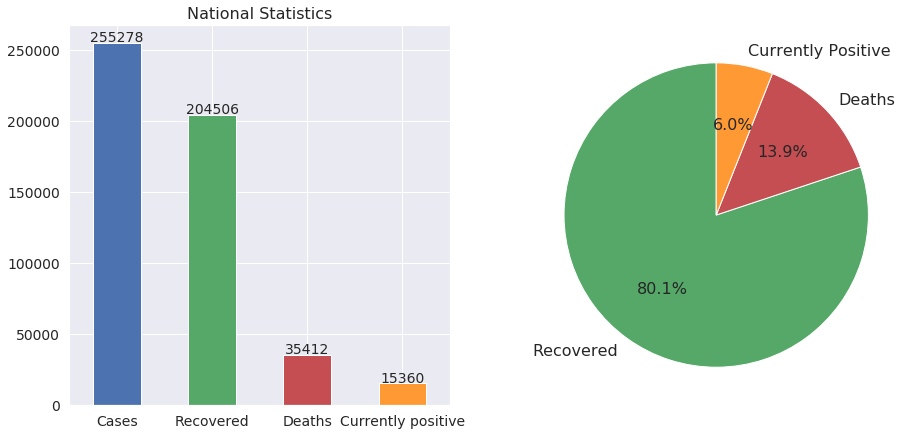

In [262]:
fig, axes = plt.subplots(1, 2, figsize=(15,7))

last_day = df_reg.index.max()[0]
tot_cases = df_reg.loc[last_day, "totale_casi"].sum()
tot_recovered = df_reg.loc[last_day, "dimessi_guariti"].sum()
tot_deaths = df_reg.loc[last_day, "deceduti"].sum()
currently_positive = tot_cases - (tot_recovered + tot_deaths)
index = ["Cases", "Recovered", "Deaths", "Currently positive"]

series = pd.Series([tot_cases, tot_recovered, tot_deaths, currently_positive], index=index)

color_list = ["b", "g", "r", "#ff9933"]
ax = series.plot(kind='bar', title="National Statistics", ax=axes[0], color=color_list, rot=0, fontsize=14)
ax.title.set_size(16)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+p.get_width()/2., p.get_height()), fontsize=14,
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

index = ["Recovered", "Deaths", "Currently Positive"]
series = pd.Series([tot_recovered, tot_deaths, currently_positive], index = index)
color_list = ["g", "r", "#ff9933"]
ax = series.plot(kind='pie', ax=axes[1], colors=color_list, autopct='%1.1f%%',
        startangle=90, shadow=False, legend = False, fontsize=16)
ax.set_ylabel(None);


Since the beginning of the emergency the ICP registered that in Italy more than 250 thousand have been infected by COVID-19, with more than 35 thousand of victims (13.9% mortality).  
This death rate may appear huge, but doing some research it can be found that ICP data does not take into consideration the serological tests conducted by the ASLs. These tests revealed a lot of recovered asymptomatic subjects that did not know they had been infected.

---

It could be interesting to study the national data trend over time:

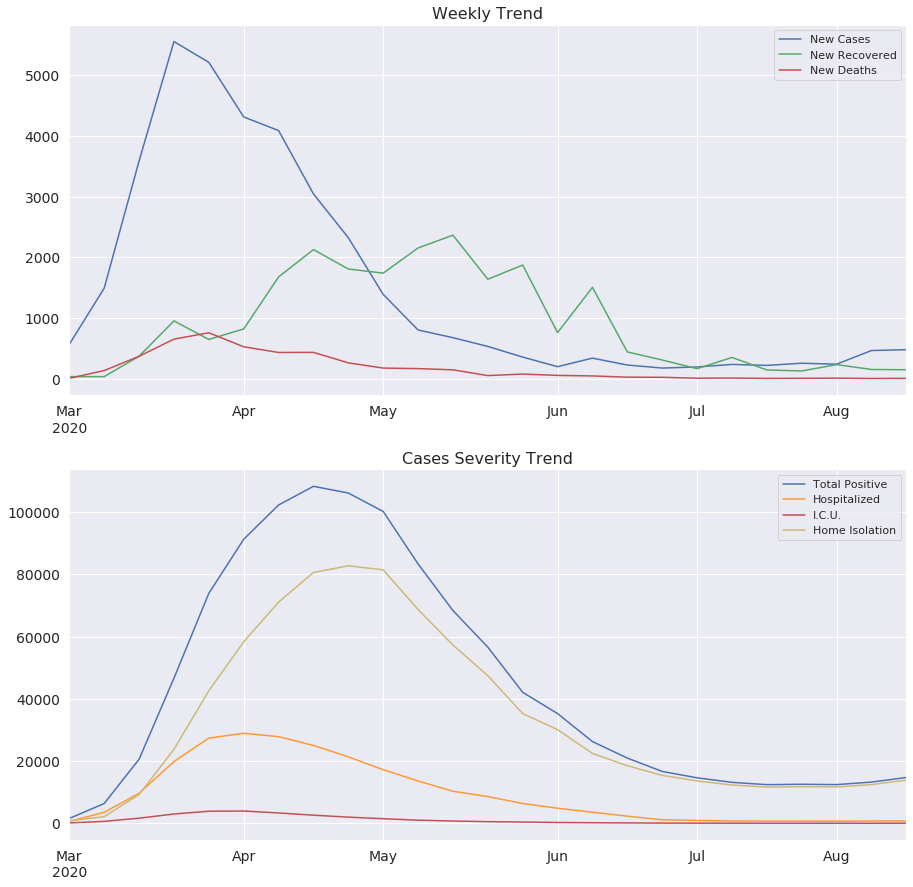

In [263]:
# Sample data by week
df_data = df_reg[["totale_casi", "dimessi_guariti", "deceduti"]].groupby(level="data").sum()#.asfreq("W")
df_weekly_trend = (df_data - df_data.shift(+1)).asfreq("W")
df_weekly_trend.columns = ["New Cases", "New Recovered", "New Deaths"]

df_positives = df_reg[["totale_positivi", "ricoverati_con_sintomi", "terapia_intensiva", "isolamento_domiciliare"]].groupby(level="data").sum().asfreq("W")
df_positives.columns = ["Total Positive", "Hospitalized", "I.C.U.", "Home Isolation"]

# Plot the data
fig, axes = plt.subplots(2, 1, figsize=(15,15))
color_list = ["b", "g", "r"]

# Plot cases/recovered/deaths trend
ax = df_weekly_trend.plot(title="Weekly Trend", ax=axes[0], color=color_list, fontsize=14)
ax.set_xlabel(None)
ax.title.set_size(16)

# Plot severity trend
color_list = ["b", "#ff9933", "r", "y"]
ax = df_positives.plot(title="Cases Severity Trend", ax=axes[1], color=color_list, fontsize=14)
ax.set_xlabel(None)
ax.title.set_size(16)

From the first chart we can observe a peak of new infected at the end of March (with almost 40 thousand of registered cases in a single week). Since then, the number of new infected continued to decline until June, when they stabilized at a few thousands of cases per week.  
The lockdown started in mid-March, and according to data it took about two weeks to show its results and about two months to get us out from the health emergency.  

Looking also at the second chart, the most of infected occured in April, but the severity of the disease (in terms of hospitalized and Intensive Care Unit subjects) was stronger at the end of March, the same period when the new infected peak occured. Since the start of April the subjects in home isolation were the most part of the detected cases. We can think that the huge growth of infected at the end of March made difficult to give adequate care to all the patients. In April the medical community began to gain experience on how to treat COVID-19 patients and the hospitals started receiving adequate equipment, hence the situation in the health facility gradually became treatable.

The precautions and the social distancing made sure that the contagion did not spread again after the end of the lockdown, but in the last weeks (the first of August) a new growth of infections had been registered. This is attributable to people returning from holidays in foreign country and not respecting the known rules on vacation.

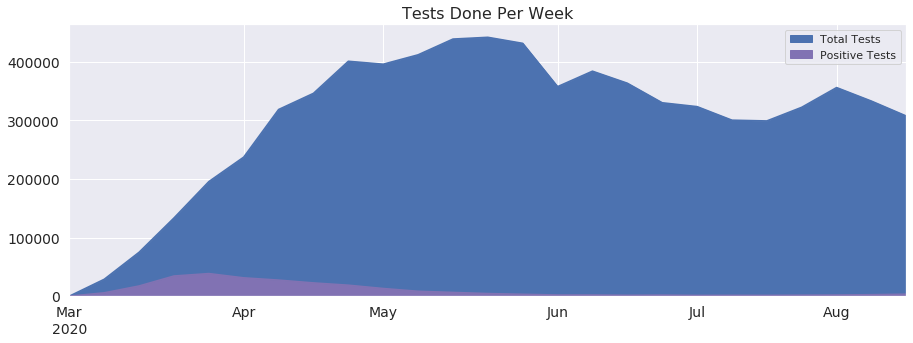

In [264]:
df_weekly_data = df_reg[["tamponi", "totale_casi"]].groupby(level=0).sum().asfreq("W")
df_weekly_trend = df_weekly_data - df_weekly_data.shift(+1)
df_weekly_trend.columns = ["Total Tests", "Positive Tests"]

color_list = ["m", "b"]
ax = df_weekly_trend.plot.area(y="Total Tests", title="Tests Done Per Week", color="b", figsize=(15, 5), fontsize=14)
ax = df_weekly_trend.plot.area(y="Positive Tests", color="m", ax=ax)
ax.set_xlabel(None)
ax.title.set_size(16)

The poor number of swab tests done in the first weeks shows that even if we were in the middle of the pandemic crysis the health facilities were not equipped to perform and elaborate a massive number of tests.  
We can also see that even if the number of performed tests per week growth over the time, the number of positive ones decreased.

## 4. Analysis of absolute regional data<a name="section_4"></a>

In this section we want to analyze the data on a regional basis.

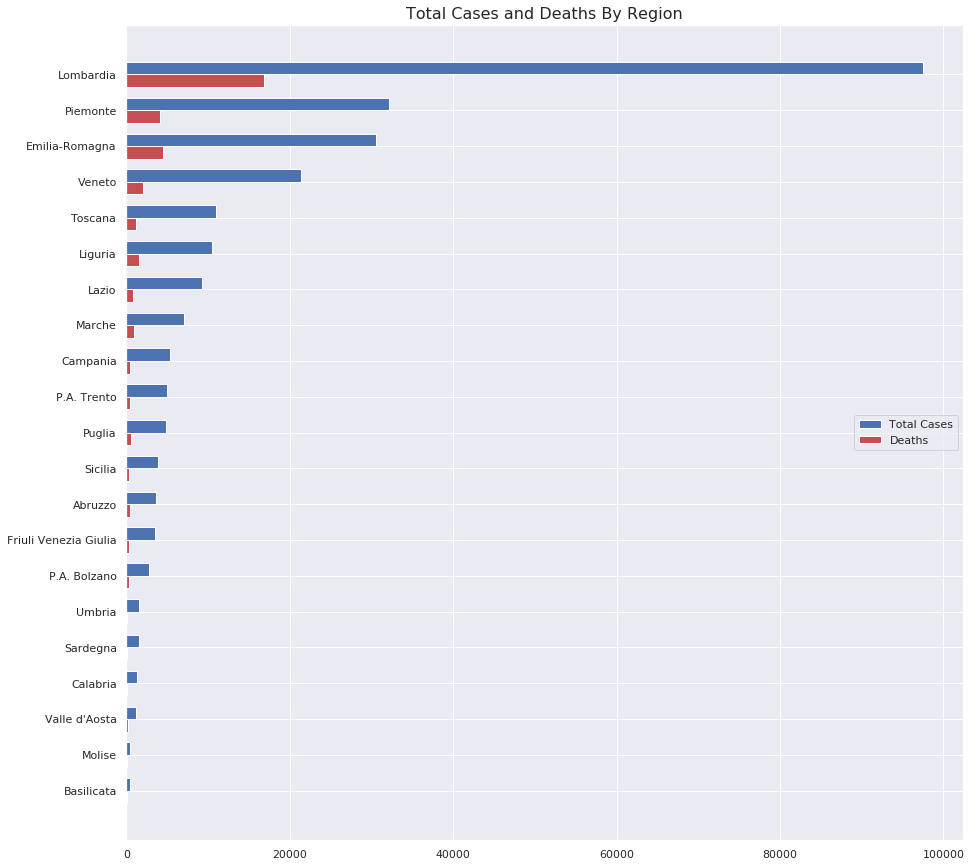

In [265]:
# Compute overall total cases and deaths by region
last_day = df_reg.index.max()[0]
source_data = pd.DataFrame(df_reg.loc[last_day, ["totale_casi", "deceduti"]].sort_values("totale_casi", ascending=True)).reset_index()
ind = np.arange(len(source_data.index))  # the x locations for the groups
height = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 15))
rects1 = ax.barh(ind + height/2, source_data["totale_casi"], height,
                label='Total Cases', color="b")
rects2 = ax.barh(ind - height/2, source_data["deceduti"], height,
                label='Deaths', color="r")

ax.set_xlabel(None)
ax.set_title('Total Cases and Deaths By Region')
ax.set_yticks(ind)
ax.set_yticklabels(source_data["denominazione_regione"])
ax.legend(loc="center right");
ax.title.set_size(16)

We can observe that the most affected regions are the northern ones: Lombardia, Piemonte, Veneto and Emilia-Romagna. Furthermore Lombardia alone registered a huge number of total cases and deaths, that it is almost three times the ones of the second most affected region (Piemonte).
Among the least affected regions we can find almost all the southern ones.

We can focus on the cited regions and compare their data to the ones of all the others added together.

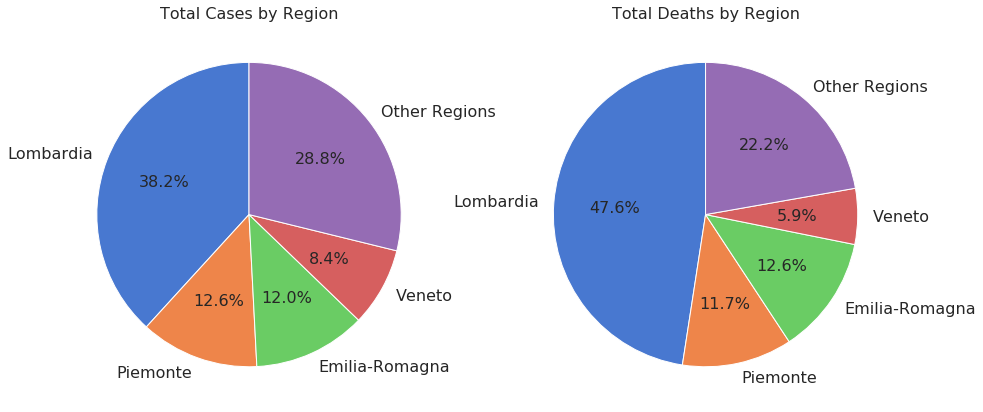

In [266]:
regions_of_interest = ["Lombardia", "Piemonte", "Emilia-Romagna", "Veneto"]

# Get cases of regions of interest
df_cases_by_region = df_reg.loc[last_day].pivot_table("totale_casi", index="denominazione_regione")
df_cases_of_interest = df_cases_by_region.loc[regions_of_interest]
df_cases_of_interest.loc["Other Regions"] = df_cases_by_region[~df_cases_by_region.index.isin(regions_of_interest)].sum()

# Get deaths of regions of interest
df_deaths_by_region = df_reg.loc[last_day].pivot_table("deceduti", index="denominazione_regione")
df_deaths_of_interest = df_deaths_by_region.loc[regions_of_interest]
df_deaths_of_interest.loc["Other Regions"] = df_deaths_by_region[~df_deaths_by_region.index.isin(regions_of_interest)].sum()

fig, axes = plt.subplots(1, 2, figsize=(15,7))
ax = df_cases_of_interest.plot(kind='pie', ax=axes[0], title="Total Cases by Region", y="totale_casi",
                               colors=sns.color_palette("muted", len(df_cases_of_interest.index)),
                               autopct='%1.1f%%', startangle=90, shadow=False, legend = False, fontsize=16)
ax.set_ylabel(None)
ax.title.set_size(16);

ax = df_deaths_of_interest.plot(kind='pie', ax=axes[1], title="Total Deaths by Region", y="deceduti",
                               colors=sns.color_palette("muted", len(df_cases_of_interest.index)),
                               autopct='%1.1f%%', startangle=90, shadow=False, legend = False, fontsize=16)

ax.set_ylabel(None)
ax.title.set_size(16);

These pie charts show that the considered northern regions had over 70% of total infected italian people. It is interesting to note that Lombardia registered almost 50% of the overall deaths.

---

It could be interesting to study the trend of data for each region over time, compared to the national average statistics.

In [267]:
df_inf_by_region = df_reg[["totale_casi", "deceduti"]].unstack().asfreq("W")
df_inf_by_region.head()

totale_casi                                              \
denominazione_regione     Abruzzo Basilicata Calabria Campania Emilia-Romagna   
data                                                                            
2020-03-01                      5          0        1       17            285   
2020-03-08                     17          4        9      101           1180   
2020-03-15                    137         11       68      333           3093   
2020-03-22                    587         81      273      936           7555   
2020-03-29                   1293        202      614     1759          13119   

                                                                            \
denominazione_regione Friuli Venezia Giulia Lazio Liguria Lombardia Marche   
data                                                                         
2020-03-01                                6     6      25       984     25   
2020-03-08                               57    87      78      4189    272   
2020-03-15                              347   436     559     13272   1133   
2020-03-22                              874  1383    1665     27206   2421   
2020-03-29                             1480  2706    3076     41007   3558   

                       ...     deceduti                                       \
denominazione_regione  ... P.A. Bolzano P.A. Trento Piemonte Puglia Sardegna   
data                   ...                                                     
2020-03-01             ...            0           0        0      0        0   
2020-03-08             ...            0           0        5      3        0   
2020-03-15             ...            5           6       81     16        2   
2020-03-22             ...           23          35      283     31        7   
2020-03-29             ...           64         129      684     86       27   

                                                                   
denominazione_regione Sicilia Toscana Umbria Valle d'Aosta Veneto  
data                                                               
2020-03-01                  0       0      0             0      2  
2020-03-08                  0       0      0             0     18  
2020-03-15                  2       8      1             1     63  
2020-03-22                  8      91     16             9    169  
2020-03-29                 65     215     31            43    392  

[5 rows x 42 columns]

In [268]:
df_national_mean = df_reg[["totale_casi", "deceduti"]].mean(level="data").asfreq("W")
df_national_mean.head()

,totale_casi,deceduti
data,,
2020-03-01,80.666667,1.619048
2020-03-08,351.190476,17.428571
2020-03-15,1178.428571,86.142857
2020-03-22,2816.095238,260.761905
2020-03-29,4651.857143,513.285714


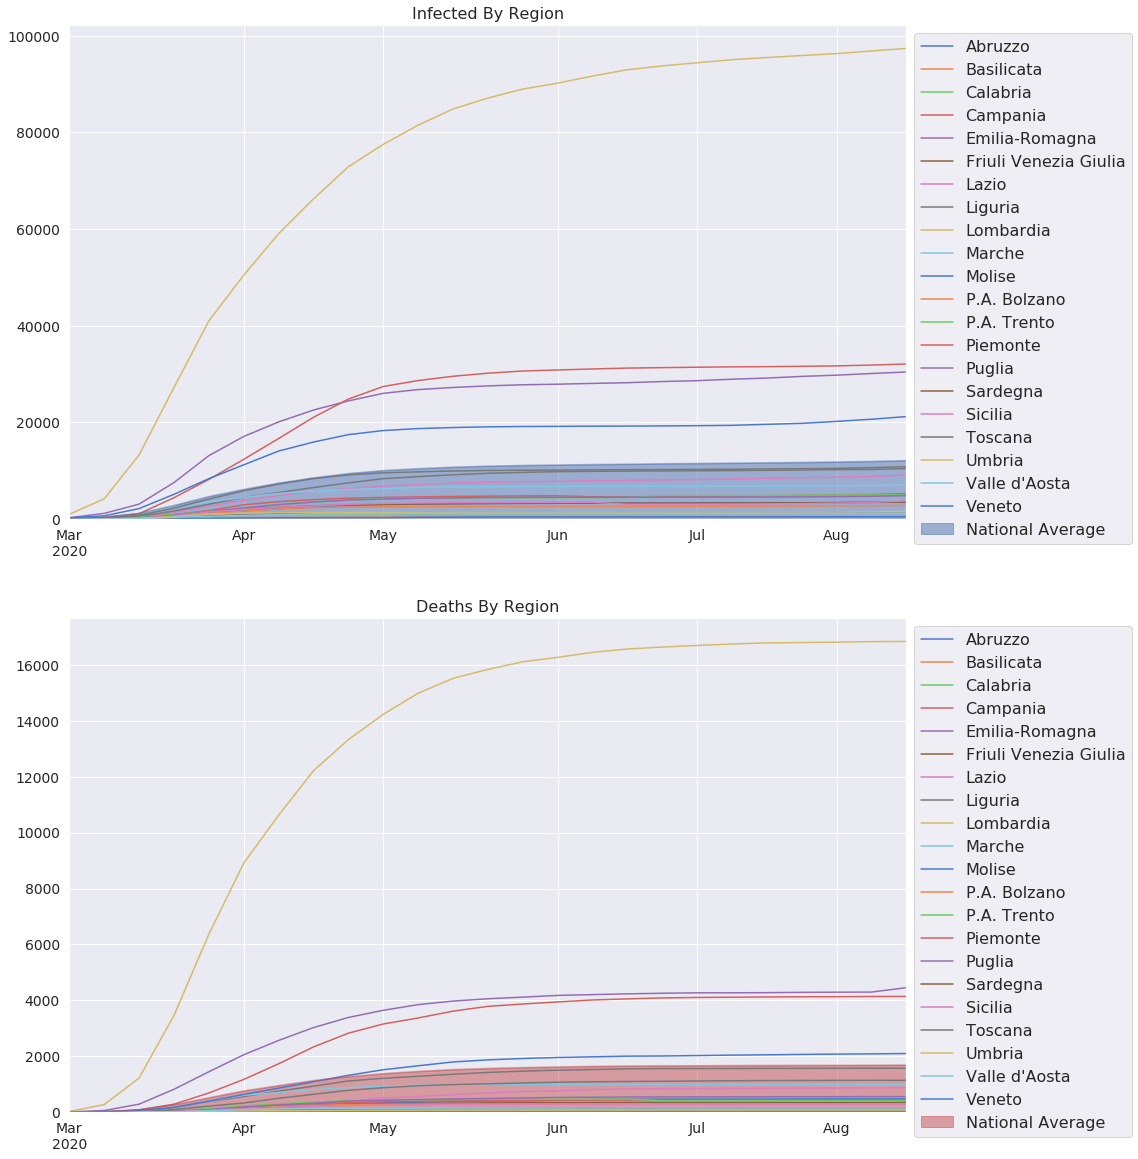

In [269]:
fig, axes = plt.subplots(2, 1, figsize=(15,20))

# Plot infected trend
ax = df_inf_by_region["totale_casi"].plot(title="Infected By Region", ax=axes[0],
                           color=sns.color_palette("muted", len(df_inf_by_region.index)), fontsize=14)
ax.set_xlabel(None)
ax.title.set_size(16)

ax = df_national_mean["totale_casi"].plot.area(ax=axes[0], alpha=0.5)
ax.set_xlabel(None)
ax.legend(fontsize=16,loc='upper left', bbox_to_anchor=(1.0, 1.0));
ax.get_legend().texts[-1].set_text("National Average")

# Plot death trend
ax = df_inf_by_region["deceduti"].plot(title="Deaths By Region", ax=axes[1],
                           color=sns.color_palette("muted", len(df_inf_by_region.index)), fontsize=14)
ax.set_xlabel(None)
ax.title.set_size(16)

ax = df_national_mean["deceduti"].plot.area(ax=axes[1], alpha=0.5, color='r')
ax.set_xlabel(None)
ax.legend(fontsize=16,loc='upper left', bbox_to_anchor=(1.0, 1.0));
ax.get_legend().texts[-1].set_text("National Average")

The first chart shows the trend of the number of infected by region compared to the national average data.  
We can see that the number of infected grew rapidly between March and May. After this period the increasing of the infected people is much slower. Only Lombardia, Piemonte, Veneto and Emilia-Romagna stand out significantly from the national mean. This can lead us to think that the spread of the disease was kept under control in most regions.

The second chart shows the trend of the number of deaths in each region, still compared to the national average. 
It has a similar trend of the first graph, just as expected. There is a slightly temporal delay on the growth of the death compared to the infected. 
We can also see that the difference between the previously citated region and the national average decrease, except for Lombardia. This can let us think that Lombardia has a higher number of people particulary weak to the infection or that the health infrastructure had some difficulties at dealing with the infected people.  
Furthemore, the trend of Veneto si really close to the national average, suggesting a lower death rate than the other affected regions.

---

Let us do the same thing to evaluate the severity of cases by region over time.

In [270]:
df_severity_by_reg = df_reg[["totale_positivi", "ricoverati_con_sintomi", "terapia_intensiva"]].unstack().asfreq("W")
df_severity_by_reg.head()

totale_positivi                               \
denominazione_regione         Abruzzo Basilicata Calabria Campania   
data                                                                 
2020-03-01                          5          0        1       17   
2020-03-08                         17          4        9      100   
2020-03-15                        128         11       66      296   
2020-03-22                        539         81      260      866   
2020-03-29                       1169        197      577     1556   

                                                                          \
denominazione_regione Emilia-Romagna Friuli Venezia Giulia Lazio Liguria   
data                                                                       
2020-03-01                       277                     6     3      21   
2020-03-08                      1097                    53    81      67   
2020-03-15                      2741                   316   396     493   
2020-03-22                      6390                   738  1272    1351   
2020-03-29                     10535                  1141  2362    2279   

                                        ... terapia_intensiva              \
denominazione_regione Lombardia Marche  ...      P.A. Bolzano P.A. Trento   
data                                    ...                                 
2020-03-01                  887     25  ...                 0           0   
2020-03-08                 3372    265  ...                 0           2   
2020-03-15                10043   1087  ...                 4          19   
2020-03-22                17885   2231  ...                32          46   
2020-03-29                25392   3160  ...                56          75   

                                                                       \
denominazione_regione Piemonte Puglia Sardegna Sicilia Toscana Umbria   
data                                                                    
2020-03-01                   2      0        0       0       0      0   
2020-03-08                  45      3        0       0       7      2   
2020-03-15                 171      6        0      15     107     13   
2020-03-22                 308     37       16      55     215     35   
2020-03-29                 443     99       23      71     275     46   

                                            
denominazione_regione Valle d'Aosta Veneto  
data                                        
2020-03-01                        0     13  
2020-03-08                        0     47  
2020-03-15                        3    129  
2020-03-22                       21    255  
2020-03-29                       26    355  

[5 rows x 63 columns]

In [271]:
df_national_mean = df_reg[["totale_positivi", "ricoverati_con_sintomi", "terapia_intensiva"]].mean(level="data").asfreq("W")
df_national_mean.head()

,totale_positivi,ricoverati_con_sintomi,terapia_intensiva
data,,,
2020-03-01,75.095238,30.428571,6.666667
2020-03-08,304.142857,169.380952,30.952381
2020-03-15,981.095238,460.142857,79.619048
2020-03-22,2220.857143,945.047619,143.285714
2020-03-29,3518.095238,1304.095238,186.000000


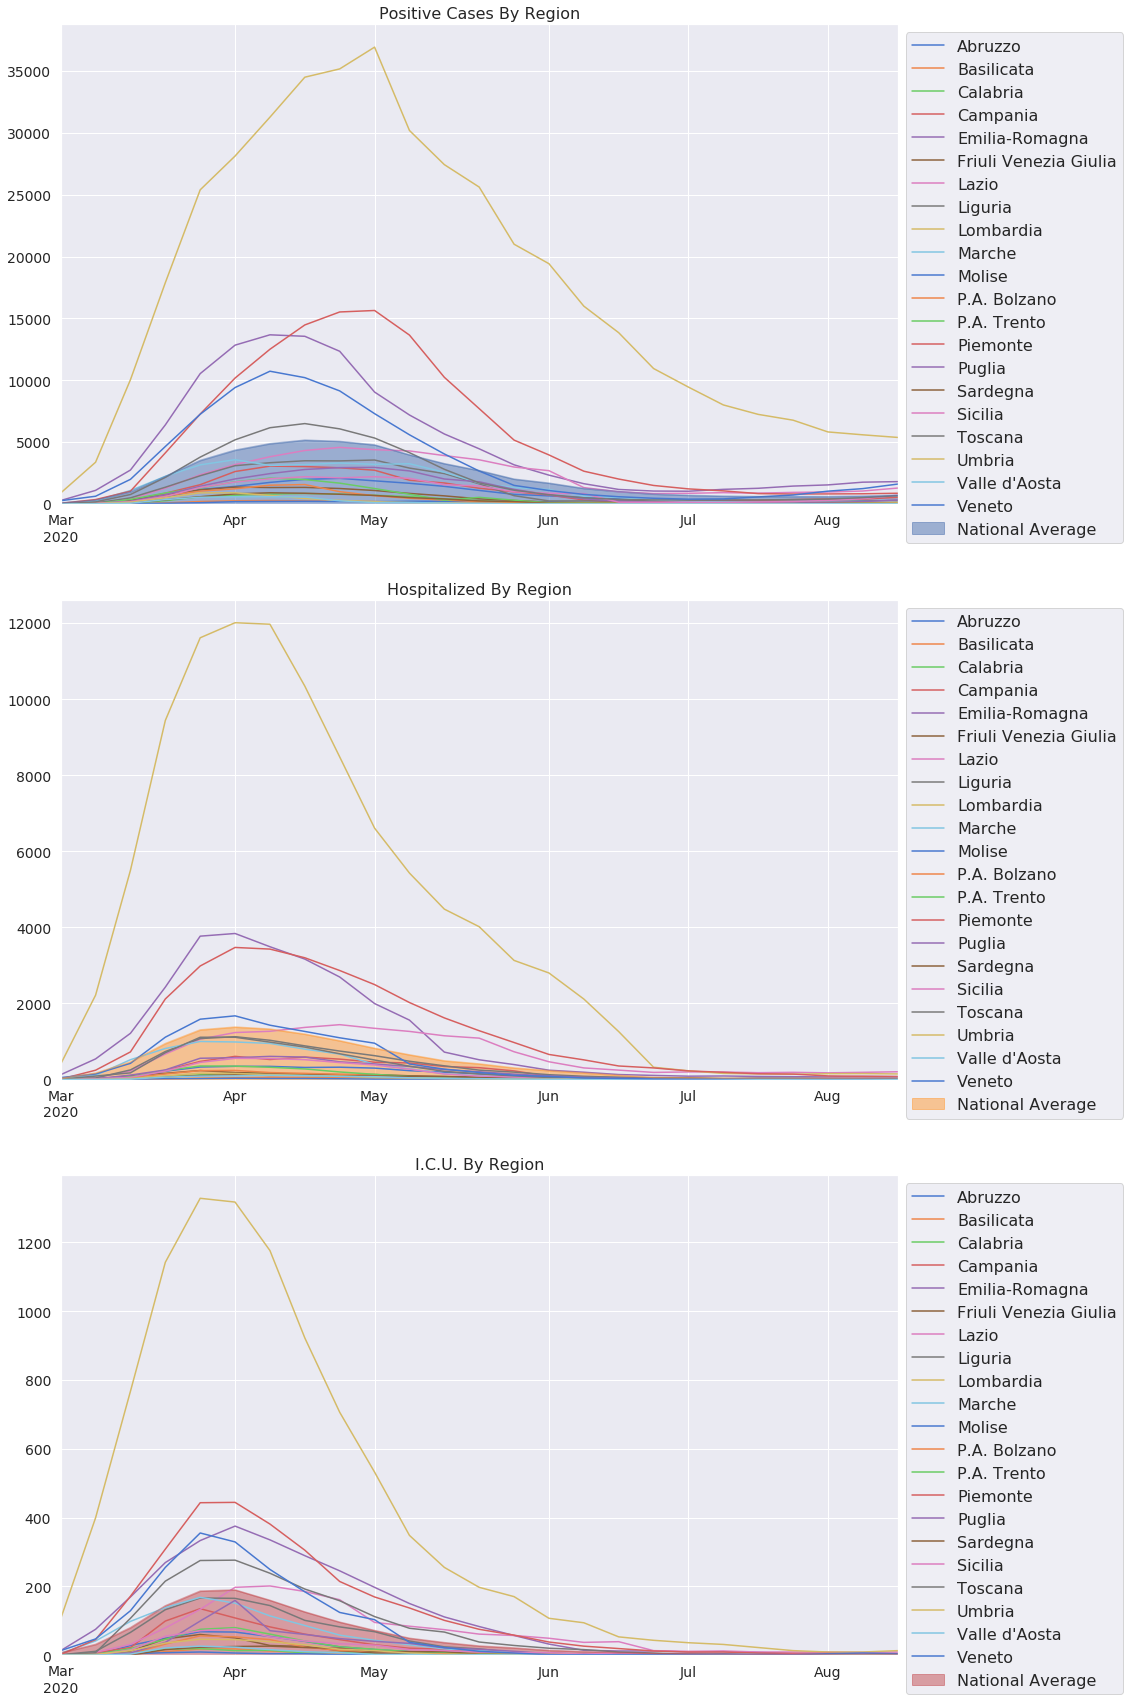

In [272]:
fig, axes = plt.subplots(3, 1, figsize=(15,30))

# Plot currently positive cases
ax = df_severity_by_reg["totale_positivi"].plot(title="Positive Cases By Region", ax=axes[0],
                           color=sns.color_palette("muted", len(df_inf_by_region.index)), fontsize=14)
ax.set_xlabel(None)
ax.title.set_size(16)

ax = df_national_mean["totale_positivi"].plot.area(ax=axes[0], color="b", alpha=0.5)
ax.set_xlabel(None)
ax.legend(fontsize=16,loc='upper left', bbox_to_anchor=(1.0, 1.0));
ax.get_legend().texts[-1].set_text("National Average")

# Plot hospitalized trend
ax = df_severity_by_reg["ricoverati_con_sintomi"].plot(title="Hospitalized By Region", ax=axes[1],
                           color=sns.color_palette("muted", len(df_inf_by_region.index)), fontsize=14)
ax.set_xlabel(None)
ax.title.set_size(16)

ax = df_national_mean["ricoverati_con_sintomi"].plot.area(ax=axes[1], color="#ff9933", alpha=0.5)
ax.set_xlabel(None)
ax.legend(fontsize=16,loc='upper left', bbox_to_anchor=(1.0, 1.0));
ax.get_legend().texts[-1].set_text("National Average")

# Plot ICU trend
ax = df_severity_by_reg["terapia_intensiva"].plot(title="I.C.U. By Region", ax=axes[2],
                           color=sns.color_palette("muted", len(df_inf_by_region.index)), fontsize=14)
ax.set_xlabel(None)
ax.title.set_size(16)

ax = df_national_mean["terapia_intensiva"].plot.area(ax=axes[2], color="r", alpha=0.5)
ax.set_xlabel(None)
ax.legend(fontsize=16,loc='upper left', bbox_to_anchor=(1.0, 1.0));
ax.get_legend().texts[-1].set_text("National Average")

From the first chart we can observe that Lombardia and Piemonte had the peak of infected later than all the other regions.  
The Hospitalized and the ICU charts have similar trends, and their peaks occurred earlier than the positive cases peak.  
Finally, we can see that the data of Lazio differs from all the other regions trends, standing out from the national average after April.

## 5. Analysis of regional data with respect to the population<a name="section_5"></a>

In this section we want to analyze the same data of the previous section but compared to the population of each region.

We first load the italian population data updated in January 2020. These data can be found at [http://dati.istat.it/Index.aspx?DataSetCode=DCIS_POPRES1](http://dati.istat.it/Index.aspx?DataSetCode=DCIS_POPRES1), however we had to do a manual clean operation to transform the .xls file into a readable .csv one because of some errors in the csv file generated by ISTAT.

In [273]:
df_pop = pd.read_csv(os.path.join("data", "italian-population.csv"), sep=";")
df_pop.head()

,Territorio,totale
0,Italia,60244639
1,Nord-ovest,16113972
2,Piemonte,4341375
3,Torino,2252379
4,Vercelli,170296


Rename the column `totale` to avoid confusion:

In [274]:
df_pop = df_pop.rename(columns={"totale": "popolazione"})
df_pop.head()

,Territorio,popolazione
0,Italia,60244639
1,Nord-ovest,16113972
2,Piemonte,4341375
3,Torino,2252379
4,Vercelli,170296


In [275]:
df_pop["Territorio"].unique()

array(['Italia', '  Nord-ovest', '    Piemonte', '      Torino',
       '      Vercelli', '      Novara', '      Cuneo', '      Asti',
       '      Alessandria', '      Biella', '      Verbano-Cusio-Ossola',
       "    Valle d'Aosta / Vallée d'Aoste",
       "      Valle d'Aosta / Vallée d'Aoste", '    Liguria',
       '      Imperia', '      Savona', '      Genova', '      La Spezia',
       '    Lombardia', '      Varese', '      Como', '      Sondrio',
       '      Milano', '      Bergamo', '      Brescia', '      Pavia',
       '      Cremona', '      Mantova', '      Lecco', '      Lodi',
       '      Monza e della Brianza', '  Nord-est',
       '    Trentino Alto Adige / Südtirol',
       '    Provincia Autonoma Bolzano / Bozen', '      Bolzano / Bozen',
       '    Provincia Autonoma Trento', '      Trento', '    Veneto',
       '      Verona', '      Vicenza', '      Belluno', '      Treviso',
       '      Venezia', '      Padova', '      Rovigo',
       '    Friuli-Venezi

We need to remove the whitespaces from the value in order to merge the dataframe with our data:

In [276]:
df_pop["Territorio"] = df_pop["Territorio"].map(lambda x: x.strip())
df_pop["Territorio"].unique()

array(['Italia', 'Nord-ovest', 'Piemonte', 'Torino', 'Vercelli', 'Novara',
       'Cuneo', 'Asti', 'Alessandria', 'Biella', 'Verbano-Cusio-Ossola',
       "Valle d'Aosta / Vallée d'Aoste", 'Liguria', 'Imperia', 'Savona',
       'Genova', 'La Spezia', 'Lombardia', 'Varese', 'Como', 'Sondrio',
       'Milano', 'Bergamo', 'Brescia', 'Pavia', 'Cremona', 'Mantova',
       'Lecco', 'Lodi', 'Monza e della Brianza', 'Nord-est',
       'Trentino Alto Adige / Südtirol',
       'Provincia Autonoma Bolzano / Bozen', 'Bolzano / Bozen',
       'Provincia Autonoma Trento', 'Trento', 'Veneto', 'Verona',
       'Vicenza', 'Belluno', 'Treviso', 'Venezia', 'Padova', 'Rovigo',
       'Friuli-Venezia Giulia', 'Udine', 'Gorizia', 'Trieste',
       'Pordenone', 'Emilia-Romagna', 'Piacenza', 'Parma',
       "Reggio nell'Emilia", 'Modena', 'Bologna', 'Ferrara', 'Ravenna',
       'Forlì-Cesena', 'Rimini', 'Centro', 'Toscana', 'Massa-Carrara',
       'Lucca', 'Pistoia', 'Firenze', 'Livorno', 'Pisa', 'Arezzo',
  

In [277]:
df_reg.index.unique(level="denominazione_regione")

Index(['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia-Romagna',
       'Friuli Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche',
       'Molise', 'P.A. Bolzano', 'P.A. Trento', 'Piemonte', 'Puglia',
       'Sardegna', 'Sicilia', 'Toscana', 'Umbria', 'Valle d'Aosta', 'Veneto'],
      dtype='object', name='denominazione_regione')

We also need to rename 4 regions (Valle d'Aosta / Vallée d'Aoste, Friuli-Venezia Giulia,  Provincia Autonoma Bolzano / Bozen, Provincia Autonoma Trento) to do the merge:

In [278]:
df_pop.loc[df_pop["Territorio"] == "Valle d'Aosta / Vallée d'Aoste", "Territorio"] = "Valle d'Aosta"
df_pop.loc[df_pop["Territorio"] == "Friuli-Venezia Giulia", "Territorio"] = "Friuli Venezia Giulia"
df_pop.loc[df_pop["Territorio"] == "Provincia Autonoma Bolzano / Bozen", "Territorio"] = "P.A. Bolzano"
df_pop.loc[df_pop["Territorio"] == "Provincia Autonoma Trento", "Territorio"] = "P.A. Trento"
df_pop["Territorio"].unique()

array(['Italia', 'Nord-ovest', 'Piemonte', 'Torino', 'Vercelli', 'Novara',
       'Cuneo', 'Asti', 'Alessandria', 'Biella', 'Verbano-Cusio-Ossola',
       "Valle d'Aosta", 'Liguria', 'Imperia', 'Savona', 'Genova',
       'La Spezia', 'Lombardia', 'Varese', 'Como', 'Sondrio', 'Milano',
       'Bergamo', 'Brescia', 'Pavia', 'Cremona', 'Mantova', 'Lecco',
       'Lodi', 'Monza e della Brianza', 'Nord-est',
       'Trentino Alto Adige / Südtirol', 'P.A. Bolzano',
       'Bolzano / Bozen', 'P.A. Trento', 'Trento', 'Veneto', 'Verona',
       'Vicenza', 'Belluno', 'Treviso', 'Venezia', 'Padova', 'Rovigo',
       'Friuli Venezia Giulia', 'Udine', 'Gorizia', 'Trieste',
       'Pordenone', 'Emilia-Romagna', 'Piacenza', 'Parma',
       "Reggio nell'Emilia", 'Modena', 'Bologna', 'Ferrara', 'Ravenna',
       'Forlì-Cesena', 'Rimini', 'Centro', 'Toscana', 'Massa-Carrara',
       'Lucca', 'Pistoia', 'Firenze', 'Livorno', 'Pisa', 'Arezzo',
       'Siena', 'Grosseto', 'Prato', 'Umbria', 'Perugia', 'Ter

In [279]:
# Retrieve the regional data of interest, sampled by week
# We need to reset the index to merge it with the population dataframe
df = df_reg[["totale_casi", "deceduti", "tamponi", "casi_testati", \
             "totale_positivi", "ricoverati_con_sintomi"]].reset_index()
df_reg_relative = df.merge(df_pop, left_on="denominazione_regione", right_on="Territorio")
# Drop duplicate column
df_reg_relative = df_reg_relative.drop(columns="Territorio")
# Drop duplicates rows (due to Valle d'Aosta as region and province)
df_reg_relative.drop_duplicates(inplace=True)
df_reg_relative.head()

,data,denominazione_regione,totale_casi,deceduti,tamponi,casi_testati,totale_positivi,ricoverati_con_sintomi,popolazione
0,2020-02-24,Abruzzo,0,0,5,NaN,0,0,1305770
1,2020-02-25,Abruzzo,0,0,5,NaN,0,0,1305770
2,2020-02-26,Abruzzo,0,0,13,NaN,0,0,1305770
3,2020-02-27,Abruzzo,1,0,33,NaN,1,1,1305770
4,2020-02-28,Abruzzo,1,0,33,NaN,1,1,1305770


Divide columns `totale_casi`, `tamponi` and `totale_positivi` by `popolazione` to get the relative data (percentage) over the time:

In [280]:
df_reg_relative[["totale_casi", "deceduti", "tamponi", "casi_testati", "totale_positivi", "ricoverati_con_sintomi"]] = \
    df_reg_relative[["totale_casi", "deceduti", "tamponi", "casi_testati", "totale_positivi", "ricoverati_con_sintomi"]].div(df_reg_relative["popolazione"]/100, axis=0)
df_reg_relative.head()

,data,denominazione_regione,totale_casi,deceduti,tamponi,casi_testati,totale_positivi,ricoverati_con_sintomi,popolazione
0,2020-02-24,Abruzzo,0.000000,0.0,0.000383,NaN,0.000000,0.000000,1305770
1,2020-02-25,Abruzzo,0.000000,0.0,0.000383,NaN,0.000000,0.000000,1305770
2,2020-02-26,Abruzzo,0.000000,0.0,0.000996,NaN,0.000000,0.000000,1305770
3,2020-02-27,Abruzzo,0.000077,0.0,0.002527,NaN,0.000077,0.000077,1305770
4,2020-02-28,Abruzzo,0.000077,0.0,0.002527,NaN,0.000077,0.000077,1305770


Rebuild the index using `data` and `denominazione_regione`:

In [281]:
df_reg_relative = df_reg_relative.set_index(['data', 'denominazione_regione'])
df_reg_relative.sort_index(inplace=True)
df_reg_relative.head()

totale_casi  deceduti   tamponi  \
data       denominazione_regione                                    
2020-02-24 Abruzzo                   0.000000       0.0  0.000383   
           Basilicata                0.000000       0.0  0.000000   
           Calabria                  0.000000       0.0  0.000052   
           Campania                  0.000000       0.0  0.000173   
           Emilia-Romagna            0.000403       0.0  0.003313   

                                  casi_testati  totale_positivi  \
data       denominazione_regione                                  
2020-02-24 Abruzzo                         NaN         0.000000   
           Basilicata                      NaN         0.000000   
           Calabria                        NaN         0.000000   
           Campania                        NaN         0.000000   
           Emilia-Romagna                  NaN         0.000403   

                                  ricoverati_con_sintomi  popolazione  
data       denominazione_regione                                       
2020-02-24 Abruzzo                              0.000000      1305770  
           Basilicata                           0.000000       556934  
           Calabria                             0.000000      1924701  
           Campania                             0.000000      5785861  
           Emilia-Romagna                       0.000224      4467118

In [282]:
df_reg_relative.describe()

,totale_casi,deceduti,tamponi,casi_testati,totale_positivi,ricoverati_con_sintomi,popolazione
count,3738.000000,3738.000000,3738.000000,2583.000000,3738.000000,3738.000000,3.738000e+03
mean,0.285052,0.034196,6.237566,5.529391,0.059555,0.011989,2.868792e+06
std,0.282806,0.040786,6.090266,2.869800,0.085929,0.020495,2.494442e+06
min,0.000000,0.000000,0.000000,0.387040,0.000000,0.000000,1.255010e+05
25%,0.069186,0.005028,1.141948,3.257621,0.007171,0.000672,8.802850e+05
50%,0.158478,0.013226,4.890006,5.175245,0.020741,0.002978,1.630474e+06
75%,0.451182,0.054879,9.268538,7.290586,0.069675,0.011942,4.467118e+06
max,0.972104,0.166707,31.820636,14.400292,0.485255,0.119527,1.010397e+07


---

Let us analyze the total data (data about the last available day) with respect to the population.

In [283]:
last_day = df_reg_relative.index[-1][0]
df_total_data = pd.DataFrame(df_reg_relative.loc[last_day, ["totale_casi", "tamponi", "casi_testati"]].sort_values("totale_casi", ascending=True)).reset_index()
df_total_data

,denominazione_regione,totale_casi,tamponi,casi_testati
0,Calabria,0.071024,7.252763,7.147084
1,Sicilia,0.077248,6.357567,4.902474
2,Basilicata,0.088341,9.270039,9.128191
3,Campania,0.093383,6.381539,3.403746
4,Sardegna,0.095003,7.373193,6.227882
5,Puglia,0.122621,6.826642,4.745084
6,Lazio,0.158485,7.984238,6.519208
7,Molise,0.166410,10.076919,9.683556
8,Umbria,0.177556,15.509068,9.767973
9,Abruzzo,0.273938,10.954533,7.095890


In [284]:
df_total_data.describe()

,totale_casi,tamponi,casi_testati
count,21.000000,21.000000,21.000000
mean,0.395550,14.206493,8.626523
std,0.315739,7.442003,2.873215
min,0.071024,6.357567,3.403746
25%,0.122621,7.984238,7.095890
50%,0.291656,12.524696,8.436768
75%,0.682445,17.684400,10.460122
max,0.972104,31.820636,14.400292


The first thing we note is that even if Lombardia was the most affected region according to absolute numbers, comparing them with the population data the most affected region appears to be Valle d'Aosta, which had almost 1% of its population infected. Half of the regions did not reach 0.3%.  
Compared to the population, the data appear much less scary.

Regarding the tests, on average regions tested about 8.6% of their population, but the standard deviation is high.

Let us see some charts about these data to have a graphical overview.

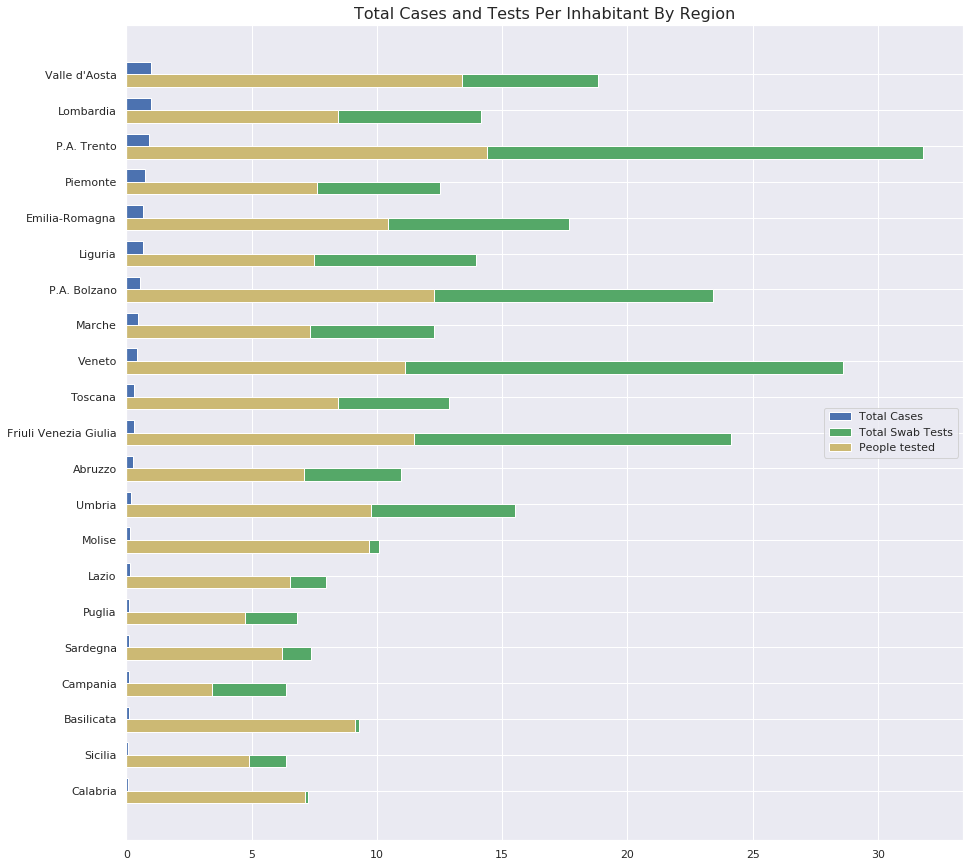

In [285]:
ind = np.arange(len(df_total_data.index))
height = 0.35

fig, ax = plt.subplots(figsize=(15, 15))
rects1 = ax.barh(ind + height/2, df_total_data["totale_casi"], height,
                label='Total Cases', color="b")
rects2 = ax.barh(ind - height/2, df_total_data["tamponi"], height,
                label='Total Swab Tests', color="g")
rects3 = ax.barh(ind - height/2, df_total_data["casi_testati"], height,
                label='People tested', color="y")

ax.set_xlabel(None)
ax.set_title('Total Cases and Tests Per Inhabitant By Region')
ax.set_yticks(ind)
ax.set_yticklabels(df_total_data["denominazione_regione"])
ax.legend(loc="center right");
ax.title.set_size(16)

P.A. Trento, Valle d'Aosta and Lombardia had about the same rate of infected, with 1 out of 100 infected.  
P.A. Trento is also the region that did the most number of swab tests pro capite: over 30% of its population was tested.
Also Veneto tested almost 30% of its population, and even if from the absolute data it appeared to be one of the most affected regions, using relative data is only at 9th place, with less than 5 out of 1000 infected.

Finally, southern regions and island are confirmed to be the less affected by COVID-19.

---

Now let us consider the data trend over time, as in the previous section.

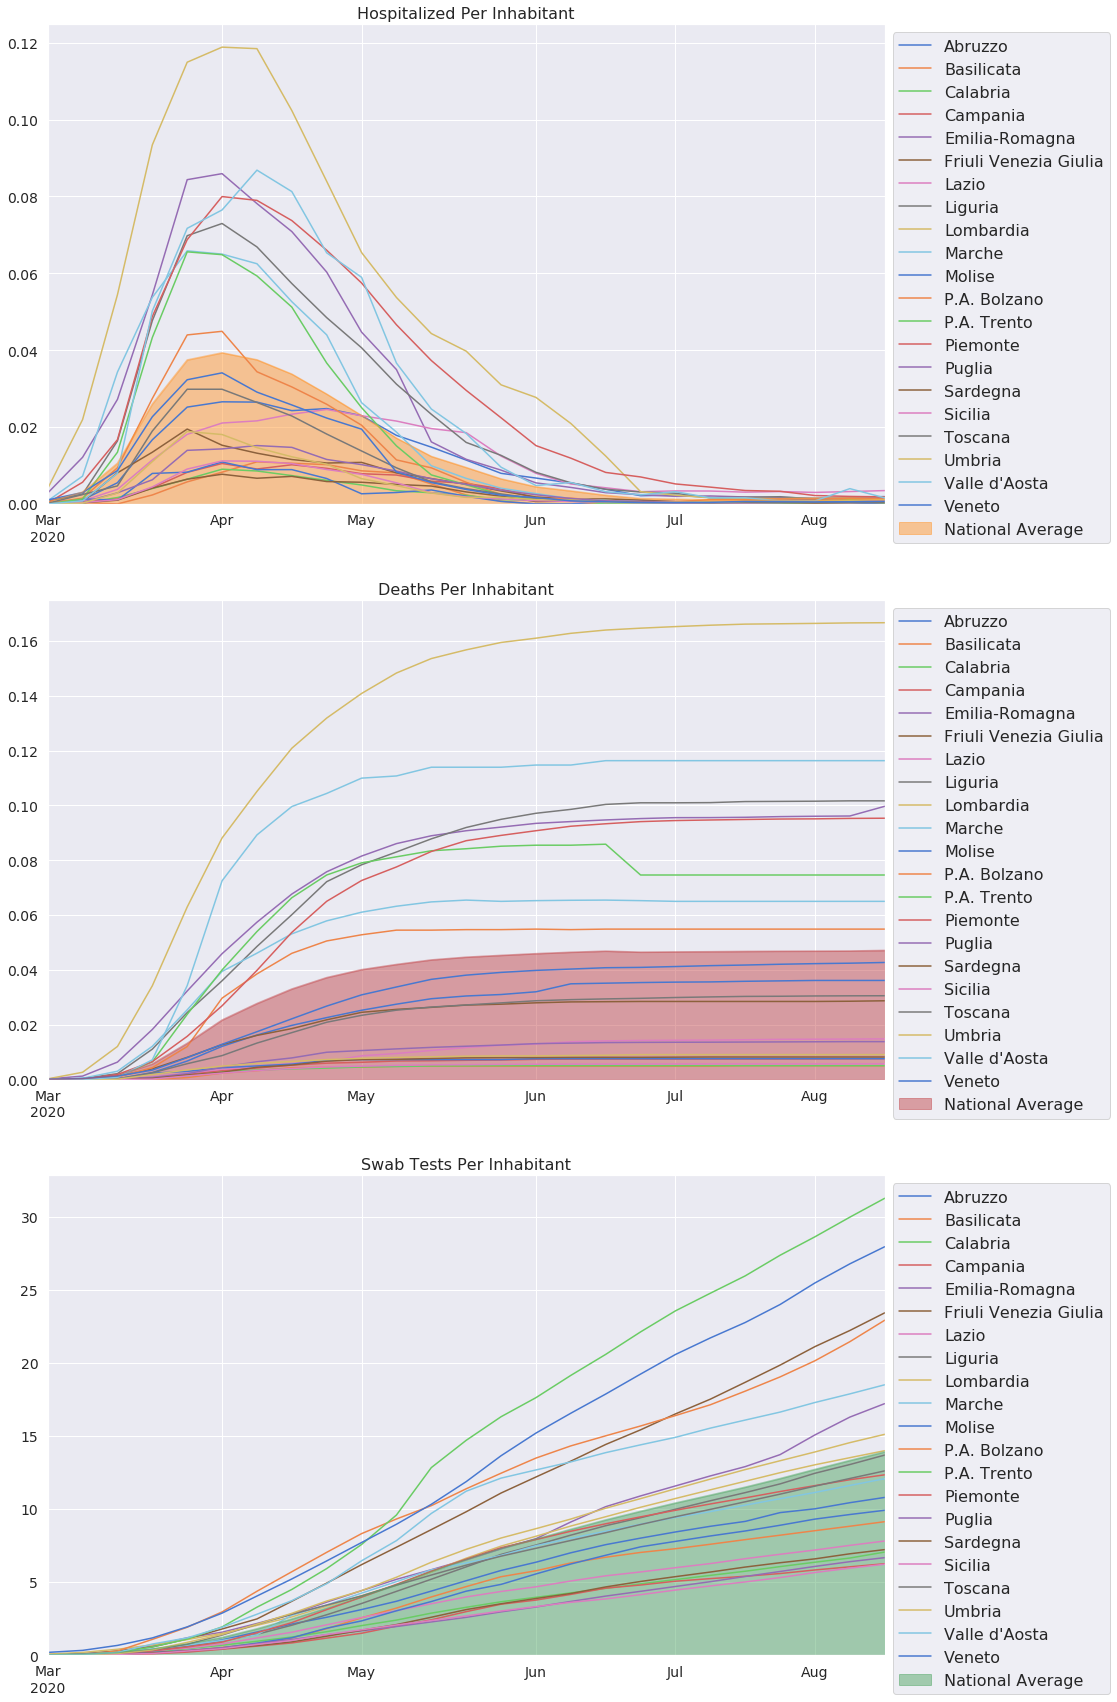

In [286]:
df_help = df_reg_relative[["totale_casi", "ricoverati_con_sintomi","deceduti","tamponi"]].unstack().asfreq("W")
df_help_mean = df_help[["totale_casi","ricoverati_con_sintomi","deceduti","tamponi"]].stack().mean(level="data").asfreq("W")

fig, axes = plt.subplots(3, 1, figsize=(15,30))

# Hospitalized Per Inhabitant
ax = df_help["ricoverati_con_sintomi"].plot(title="Hospitalized Per Inhabitant",ax=axes[0],
                           color=sns.color_palette("muted", len(df_inf_by_region.index)), fontsize=14)
ax.set_xlabel(None)
ax.title.set_size(16)

ax = df_help_mean["ricoverati_con_sintomi"].plot.area(ax=axes[0], color="#ff9933", alpha=0.5)
ax.set_xlabel(None)
ax.legend(fontsize=16,loc='upper left', bbox_to_anchor=(1.0, 1.0));
ax.get_legend().texts[-1].set_text("National Average")

# Death Per Inhabitant
ax = df_help["deceduti"].plot(title="Deaths Per Inhabitant",ax=axes[1],
                           color=sns.color_palette("muted", len(df_inf_by_region.index)), fontsize=14)
ax.set_xlabel(None)
ax.title.set_size(16)

ax = df_help_mean["deceduti"].plot.area(ax=axes[1], color="r", alpha=0.5)
ax.set_xlabel(None)
ax.legend(fontsize=16,loc='upper left', bbox_to_anchor=(1.0, 1.0));
ax.get_legend().texts[-1].set_text("National Average")

# Swab Tests Per Inhabitant
ax = df_help["tamponi"].plot(title="Swab Tests Per Inhabitant",ax=axes[2],
                           color=sns.color_palette("muted", len(df_inf_by_region.index)), fontsize=14)
ax.set_xlabel(None)
ax.title.set_size(16)

ax = df_help_mean["tamponi"].plot.area(ax=axes[2], color="g", alpha=0.5)
ax.set_xlabel(None)
ax.legend(fontsize=16,loc='upper left', bbox_to_anchor=(1.0, 1.0));
ax.get_legend().texts[-1].set_text("National Average")

In the first chart we can see that a lot of regions stand above the national average of hospitalized. The hospitalized data in Lombardia are the highest despite having one of the higher population among all the region.

The second chart shows the number of total death with respect to the population of each region. Also in this case Lombardia has the highest value. We can note a strange behaviour in the P.A. Trento data trend: its curve go down between June and July, perhaps due to an error in data.

In the last chart every region continue to do swab tests, but part of northern regions show a greater commitment.

## 6. Geographical analysis using maps<a name="section_6"></a>

In this section we analyze the data from a geographical point of view using maps.
Following the examples found at this [GitHub repository](https://github.com/napo/geopandas_esempi) we can use the ISTAT geographical data to translate our data into geographical heatmaps and scatter plots.  
The geographical data can be found at [https://www.istat.it/it/archivio/222527](https://www.istat.it/it/archivio/222527).

---

### Adding geographical information to absolute regional data
First of all we need to load the regions border data:

In [287]:
geo_regions = gpd.read_file(os.path.join("data", "Limiti01012020", "Reg01012020", "Reg01012020_WGS84.shp"))
geo_regions.head()

,COD_RIP,COD_REG,DEN_REG,SHAPE_AREA,SHAPE_LEN,geometry
0,1,1,Piemonte,2.538670e+10,1.333428e+06,"POLYGON ((456874.626 5145767.794, 456879.627 5..."
1,1,2,Valle d'Aosta,3.260854e+09,3.258364e+05,"POLYGON ((389358.653 5093659.158, 389433.654 5..."
2,1,3,Lombardia,2.386310e+10,1.511132e+06,"MULTIPOLYGON (((595652.358 5163515.659, 595847..."
3,2,4,Trentino-Alto Adige,1.360472e+10,8.598731e+05,"POLYGON ((743387.812 5219741.793, 743414.749 5..."
4,2,5,Veneto,1.834537e+10,1.140433e+06,"POLYGON ((768135.210 5175357.497, 768146.460 5..."


Then we load the province border data:

In [288]:
geo_prov = gpd.read_file(os.path.join("data", "Limiti01012020", "ProvCM01012020", "ProvCM01012020_WGS84.shp"))
geo_prov.head()

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,DEN_PROV,DEN_CM,DEN_UTS,SIGLA,TIPO_UTS,SHAPE_AREA,SHAPE_LEN,geometry
0,1,1,1,201,201,-,Torino,Torino,TO,Citta metropolitana,6.826908e+09,593389.667001,"POLYGON ((411015.006 5049970.983, 411070.006 5..."
1,1,1,2,0,2,Vercelli,-,Vercelli,VC,Provincia,2.081602e+09,458754.449021,"POLYGON ((437900.552 5088796.204, 437915.021 5..."
2,1,1,3,0,3,Novara,-,Novara,NO,Provincia,1.340250e+09,276722.284585,"POLYGON ((459146.367 5079451.275, 459180.648 5..."
3,1,1,4,0,4,Cuneo,-,Cuneo,CN,Provincia,6.894828e+09,542063.983810,"MULTIPOLYGON (((418682.124 4967085.107, 418717..."
4,1,1,5,0,5,Asti,-,Asti,AT,Provincia,1.510170e+09,356521.052241,"POLYGON ((423634.299 4998152.373, 423642.986 4..."


Try to plot regions and province maps:

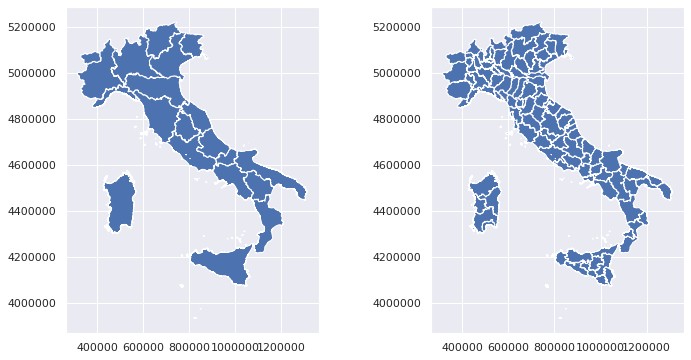

In [289]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))
geo_regions.plot(ax=axes[0]);
geo_prov.plot(ax=axes[1]);

The coordinate systems used is not the canonical latitude-longitude one. We need to do a conversion (according to the documentation of GeoPandas):

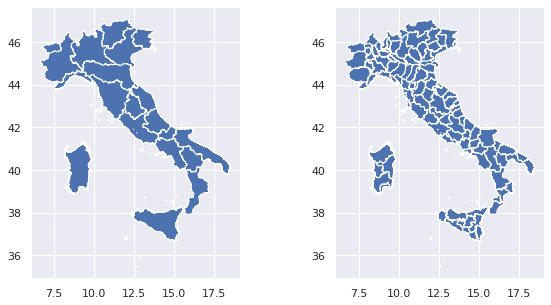

In [290]:
geo_regions = geo_regions.to_crs(epsg=4326)
geo_prov = geo_prov.to_crs(epsg=4326)

fig, axes = plt.subplots(1, 2, figsize=(10,5))
geo_regions.plot(ax=axes[0]);
geo_prov.plot(ax=axes[1]);

Now we can merge our regions data to the geographical ones:

In [291]:
last_day = df_reg.index.max()[0]
geo_data_by_region = geo_regions.merge(df_reg.loc[last_day].reset_index(), how="left",
                                       left_on="DEN_REG", right_on="denominazione_regione")
# Drop duplicates columns
geo_data_by_region.drop(["denominazione_regione", "codice_regione"], axis="columns", inplace=True)
geo_data_by_region.head()

,COD_RIP,COD_REG,DEN_REG,SHAPE_AREA,SHAPE_LEN,geometry,lat,long,ricoverati_con_sintomi,terapia_intensiva,...,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati
0,1,1,Piemonte,2.538670e+10,1.333428e+06,"POLYGON ((8.43834 46.46410, 8.43841 46.46378, ...",45.073274,7.680687,81.0,3.0,...,931.0,34.0,42.0,27096.0,4142.0,24684.0,7485.0,32169.0,543744.0,330412.0
1,1,2,Valle d'Aosta,3.260854e+09,3.258364e+05,"POLYGON ((7.57144 45.98758, 7.57241 45.98744, ...",45.737503,7.320149,1.0,0.0,...,10.0,2.0,2.0,1064.0,146.0,1102.0,118.0,1220.0,23634.0,16823.0
2,1,3,Lombardia,2.386310e+10,1.511132e+06,"MULTIPOLYGON (((10.24930 46.61838, 10.25179 46...",45.466794,9.190347,151.0,14.0,...,5322.0,8.0,91.0,75398.0,16844.0,90487.0,7077.0,97564.0,1432476.0,855372.0
3,2,4,Trentino-Alto Adige,1.360472e+10,8.598731e+05,"POLYGON ((12.20668 47.08627, 12.20703 47.08624...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,5,Veneto,1.834537e+10,1.140433e+06,"POLYGON ((12.50603 46.67803, 12.50614 46.67754...",45.434905,12.338452,39.0,6.0,...,1661.0,-27.0,59.0,17615.0,2099.0,19745.0,1630.0,21375.0,1403390.0,546505.0


In [292]:
len(geo_data_by_region.index)

20

We need to replace the Trentino-Alto Adige row with the P.A. Trento and P.A. Bolzano data (the two province are now considered as autonomous regions).  
We first need to create a dataframe with the geographical data of this two province:

In [293]:
np.sort(geo_prov["DEN_PROV"].unique())

array(['-', 'Agrigento', 'Alessandria', 'Ancona', 'Aosta', 'Arezzo',
       'Ascoli Piceno', 'Asti', 'Avellino', 'Barletta-Andria-Trani',
       'Belluno', 'Benevento', 'Bergamo', 'Biella', 'Bolzano', 'Brescia',
       'Brindisi', 'Caltanissetta', 'Campobasso', 'Caserta', 'Catanzaro',
       'Chieti', 'Como', 'Cosenza', 'Cremona', 'Crotone', 'Cuneo', 'Enna',
       'Fermo', 'Ferrara', 'Foggia', "Forli'-Cesena", 'Frosinone',
       'Gorizia', 'Grosseto', 'Imperia', 'Isernia', "L'Aquila",
       'La Spezia', 'Latina', 'Lecce', 'Lecco', 'Livorno', 'Lodi',
       'Lucca', 'Macerata', 'Mantova', 'Massa Carrara', 'Matera',
       'Modena', 'Monza e della Brianza', 'Novara', 'Nuoro', 'Oristano',
       'Padova', 'Parma', 'Pavia', 'Perugia', 'Pesaro e Urbino',
       'Pescara', 'Piacenza', 'Pisa', 'Pistoia', 'Pordenone', 'Potenza',
       'Prato', 'Ragusa', 'Ravenna', "Reggio nell'Emilia", 'Rieti',
       'Rimini', 'Rovigo', 'Salerno', 'Sassari', 'Savona', 'Siena',
       'Siracusa', 'Sondrio'

In [294]:
geo_trento_bolzano = geo_prov[(geo_prov["DEN_PROV"] == "Trento") | (geo_prov["DEN_PROV"] == "Bolzano")]
# Throws pandas warning: it is a false positive
geo_trento_bolzano.loc[geo_trento_bolzano["DEN_PROV"] == "Trento", "DEN_PROV"] = "P.A. Trento"
geo_trento_bolzano.loc[geo_trento_bolzano["DEN_PROV"] == "Bolzano", "DEN_PROV"] = "P.A. Bolzano"
geo_trento_bolzano

/home/jacopo/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,DEN_PROV,DEN_CM,DEN_UTS,SIGLA,TIPO_UTS,SHAPE_AREA,SHAPE_LEN,geometry
20,2,4,21,0,21,P.A. Bolzano,-,Bolzano,BZ,Provincia autonoma,7.397857e+09,664502.759460,"POLYGON ((12.20668 47.08627, 12.20703 47.08624..."
21,2,4,22,0,22,P.A. Trento,-,Trento,TN,Provincia autonoma,6.206864e+09,642828.097848,"POLYGON ((11.82430 46.52276, 11.82489 46.52227..."


Drop useless columns to match the `geo_data_by_region` dataframe columns:

In [295]:
# Throws pandas warning: it is a false positive
geo_trento_bolzano.drop(["COD_PROV", "COD_CM", "COD_UTS", "DEN_CM", "DEN_UTS", "TIPO_UTS"], axis="columns", inplace=True)
geo_trento_bolzano.rename(columns={"DEN_PROV": "DEN_REG"}, inplace=True)
geo_trento_bolzano

/home/jacopo/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/jacopo/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,COD_RIP,COD_REG,DEN_REG,SIGLA,SHAPE_AREA,SHAPE_LEN,geometry
20,2,4,P.A. Bolzano,BZ,7.397857e+09,664502.759460,"POLYGON ((12.20668 47.08627, 12.20703 47.08624..."
21,2,4,P.A. Trento,TN,6.206864e+09,642828.097848,"POLYGON ((11.82430 46.52276, 11.82489 46.52227..."


Merge COVID-19 data:

In [296]:
last_day = df_reg.index.max()[0]
geo_data_trento_bolzano = geo_trento_bolzano.merge(df_reg.loc[last_day].reset_index(), how="left",
                                       left_on="DEN_REG", right_on="denominazione_regione")
# Drop duplicates columns
geo_data_trento_bolzano.drop(["denominazione_regione", "codice_regione"], axis="columns", inplace=True)
geo_data_trento_bolzano

,COD_RIP,COD_REG,DEN_REG,SIGLA,SHAPE_AREA,SHAPE_LEN,geometry,lat,long,ricoverati_con_sintomi,...,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati
0,2,4,P.A. Bolzano,BZ,7.397857e+09,664502.759460,"POLYGON ((12.20668 47.08627, 12.20703 47.08624...",46.499335,11.356624,8,...,122,-5,7,2397,292,2811.0,0.0,2811,124586,65438.0
1,2,4,P.A. Trento,TN,6.206864e+09,642828.097848,"POLYGON ((11.82430 46.52276, 11.82489 46.52227...",46.068935,11.121231,2,...,44,-15,2,4559,405,3404.0,1604.0,5008,172703,78156.0


Concat the two dataframes containing the geographical and COVID-19 data:

In [297]:
# Remove Trentino-Alto Adige
geo_data_by_region = geo_data_by_region[geo_data_by_region["DEN_REG"] != "Trentino-Alto Adige"]
# And add P.A. Trento and P.A. Bolzano
geo_data_by_region = pd.concat([geo_data_by_region, geo_data_trento_bolzano], ignore_index=True)
geo_data_by_region

,COD_RIP,COD_REG,DEN_REG,SHAPE_AREA,SHAPE_LEN,geometry,lat,long,ricoverati_con_sintomi,terapia_intensiva,...,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati,SIGLA
0,1,1,Piemonte,2.538670e+10,1.333428e+06,"POLYGON ((8.43834 46.46410, 8.43841 46.46378, ...",45.073274,7.680687,81.0,3.0,...,34.0,42.0,27096.0,4142.0,24684.0,7485.0,32169.0,543744.0,330412.0,NaN
1,1,2,Valle d'Aosta,3.260854e+09,3.258364e+05,"POLYGON ((7.57144 45.98758, 7.57241 45.98744, ...",45.737503,7.320149,1.0,0.0,...,2.0,2.0,1064.0,146.0,1102.0,118.0,1220.0,23634.0,16823.0,NaN
2,1,3,Lombardia,2.386310e+10,1.511132e+06,"MULTIPOLYGON (((10.24930 46.61838, 10.25179 46...",45.466794,9.190347,151.0,14.0,...,8.0,91.0,75398.0,16844.0,90487.0,7077.0,97564.0,1432476.0,855372.0,NaN
3,2,5,Veneto,1.834537e+10,1.140433e+06,"POLYGON ((12.50603 46.67803, 12.50614 46.67754...",45.434905,12.338452,39.0,6.0,...,-27.0,59.0,17615.0,2099.0,19745.0,1630.0,21375.0,1403390.0,546505.0,NaN
4,2,6,Friuli Venezia Giulia,7.932482e+09,7.692437e+05,"MULTIPOLYGON (((13.53623 45.78427, 13.53667 45...",45.649435,13.768136,7.0,3.0,...,6.0,11.0,2975.0,348.0,3477.0,56.0,3533.0,292632.0,139117.0,NaN
5,1,7,Liguria,5.416152e+09,1.079642e+06,"MULTIPOLYGON (((8.48607 44.30832, 8.48550 44.3...",44.411493,8.932699,23.0,1.0,...,21.0,30.0,8619.0,1569.0,8619.0,1912.0,10531.0,215615.0,115811.0,NaN
6,2,8,Emilia-Romagna,2.244454e+10,1.282028e+06,"MULTIPOLYGON (((9.91741 45.09963, 9.91849 45.0...",44.494367,11.341721,81.0,7.0,...,6.0,76.0,24324.0,4455.0,28722.0,1852.0,30574.0,789983.0,467266.0,NaN
7,3,9,Toscana,2.298744e+10,1.552065e+06,"MULTIPOLYGON (((10.54136 42.93532, 10.54113 42...",43.769231,11.255889,20.0,5.0,...,28.0,40.0,9040.0,1139.0,10460.0,465.0,10925.0,479103.0,314078.0,NaN
8,3,10,Umbria,8.464223e+09,6.714160e+05,"MULTIPOLYGON (((12.35804 43.61649, 12.35857 43...",43.106758,12.388247,9.0,2.0,...,2.0,4.0,1388.0,80.0,1481.0,82.0,1563.0,136524.0,85986.0,NaN
9,3,11,Marche,9.401183e+09,7.110915e+05,"POLYGON ((12.75621 43.96864, 12.75644 43.96851...",43.616760,13.518875,13.0,1.0,...,2.0,7.0,5871.0,987.0,7065.0,0.0,7065.0,186776.0,111360.0,NaN


Finally, we add a new column storing the death rate by region:

In [298]:
geo_data_by_region["death_rate"] = geo_data_by_region["totale_casi"] / geo_data_by_region["deceduti"]
geo_data_by_region[["DEN_REG", "death_rate"]]

,DEN_REG,death_rate
0,Piemonte,7.766538
1,Valle d'Aosta,8.356164
2,Lombardia,5.792211
3,Veneto,10.183421
4,Friuli Venezia Giulia,10.152299
5,Liguria,6.711918
6,Emilia-Romagna,6.862851
7,Toscana,9.591747
8,Umbria,19.537500
9,Marche,7.158055


---

### Adding geographical information to regional data relative to the population
We repeat the same steps as above, using the relative regional data calculated in section 5:

In [299]:
last_day = df_reg_relative.index.max()[0]

# Merge geographical and COVID-19 data
geo_data_relative = geo_regions.merge(df_reg_relative.loc[last_day].reset_index(), how="left",
                                       left_on="DEN_REG", right_on="denominazione_regione")
# Drop duplicates columns
geo_data_relative.drop(["denominazione_regione"], axis="columns", inplace=True)

# Create the dataframe with the data relative to P.A. Trento and P.A. Bolzano
geo_data_trento_bolzano = geo_trento_bolzano.merge(df_reg_relative.loc[last_day].reset_index(), how="left",
                                       left_on="DEN_REG", right_on="denominazione_regione")
# Drop duplicates columns
geo_data_trento_bolzano.drop(["denominazione_regione"], axis="columns", inplace=True)

# Remove Trentino-Alto Adige
geo_data_relative = geo_data_relative[geo_data_relative["DEN_REG"] != "Trentino-Alto Adige"]
# And add P.A. Trento and P.A. Bolzano
geo_data_relative = pd.concat([geo_data_relative, geo_data_trento_bolzano], ignore_index=True)
geo_data_relative

,COD_RIP,COD_REG,DEN_REG,SHAPE_AREA,SHAPE_LEN,geometry,totale_casi,deceduti,tamponi,casi_testati,totale_positivi,ricoverati_con_sintomi,popolazione,SIGLA
0,1,1,Piemonte,2.538670e+10,1.333428e+06,"POLYGON ((8.43834 46.46410, 8.43841 46.46378, ...",0.740986,0.095408,12.524696,7.610768,0.021445,0.001866,4341375.0,NaN
1,1,2,Valle d'Aosta,3.260854e+09,3.258364e+05,"POLYGON ((7.57144 45.98758, 7.57241 45.98744, ...",0.972104,0.116334,18.831722,13.404674,0.007968,0.000797,125501.0,NaN
2,1,3,Lombardia,2.386310e+10,1.511132e+06,"MULTIPOLYGON (((10.24930 46.61838, 10.25179 46...",0.965601,0.166707,14.177359,8.465703,0.052672,0.001494,10103969.0,NaN
3,2,5,Veneto,1.834537e+10,1.140433e+06,"POLYGON ((12.50603 46.67803, 12.50614 46.67754...",0.435540,0.042769,28.595653,11.135655,0.033845,0.000795,4907704.0,NaN
4,2,6,Friuli Venezia Giulia,7.932482e+09,7.692437e+05,"MULTIPOLYGON (((13.53623 45.78427, 13.53667 45...",0.291656,0.028728,24.157371,11.484393,0.017336,0.000578,1211357.0,NaN
5,1,7,Liguria,5.416152e+09,1.079642e+06,"MULTIPOLYGON (((8.48607 44.30832, 8.48550 44.3...",0.682445,0.101677,13.972602,7.504956,0.022228,0.001490,1543127.0,NaN
6,2,8,Emilia-Romagna,2.244454e+10,1.282028e+06,"MULTIPOLYGON (((9.91741 45.09963, 9.91849 45.0...",0.684423,0.099729,17.684400,10.460122,0.040183,0.001813,4467118.0,NaN
7,3,9,Toscana,2.298744e+10,1.552065e+06,"MULTIPOLYGON (((10.54136 42.93532, 10.54113 42...",0.293468,0.030596,12.869672,8.436768,0.020039,0.000537,3722729.0,NaN
8,3,10,Umbria,8.464223e+09,6.714160e+05,"MULTIPOLYGON (((12.35804 43.61649, 12.35857 43...",0.177556,0.009088,15.509068,9.767973,0.010792,0.001022,880285.0,NaN
9,3,11,Marche,9.401183e+09,7.110915e+05,"POLYGON ((12.75621 43.96864, 12.75644 43.96851...",0.465292,0.065003,12.300843,7.334036,0.013633,0.000856,1518400.0,NaN


---

### Heatmaps
Now that we have all the data we can show some heatmaps.

It would be interesting to visually compare the distribution of the absolute number of total cases with the total cases per inhabitant, as well as the distributon of the deaths with the death rate:

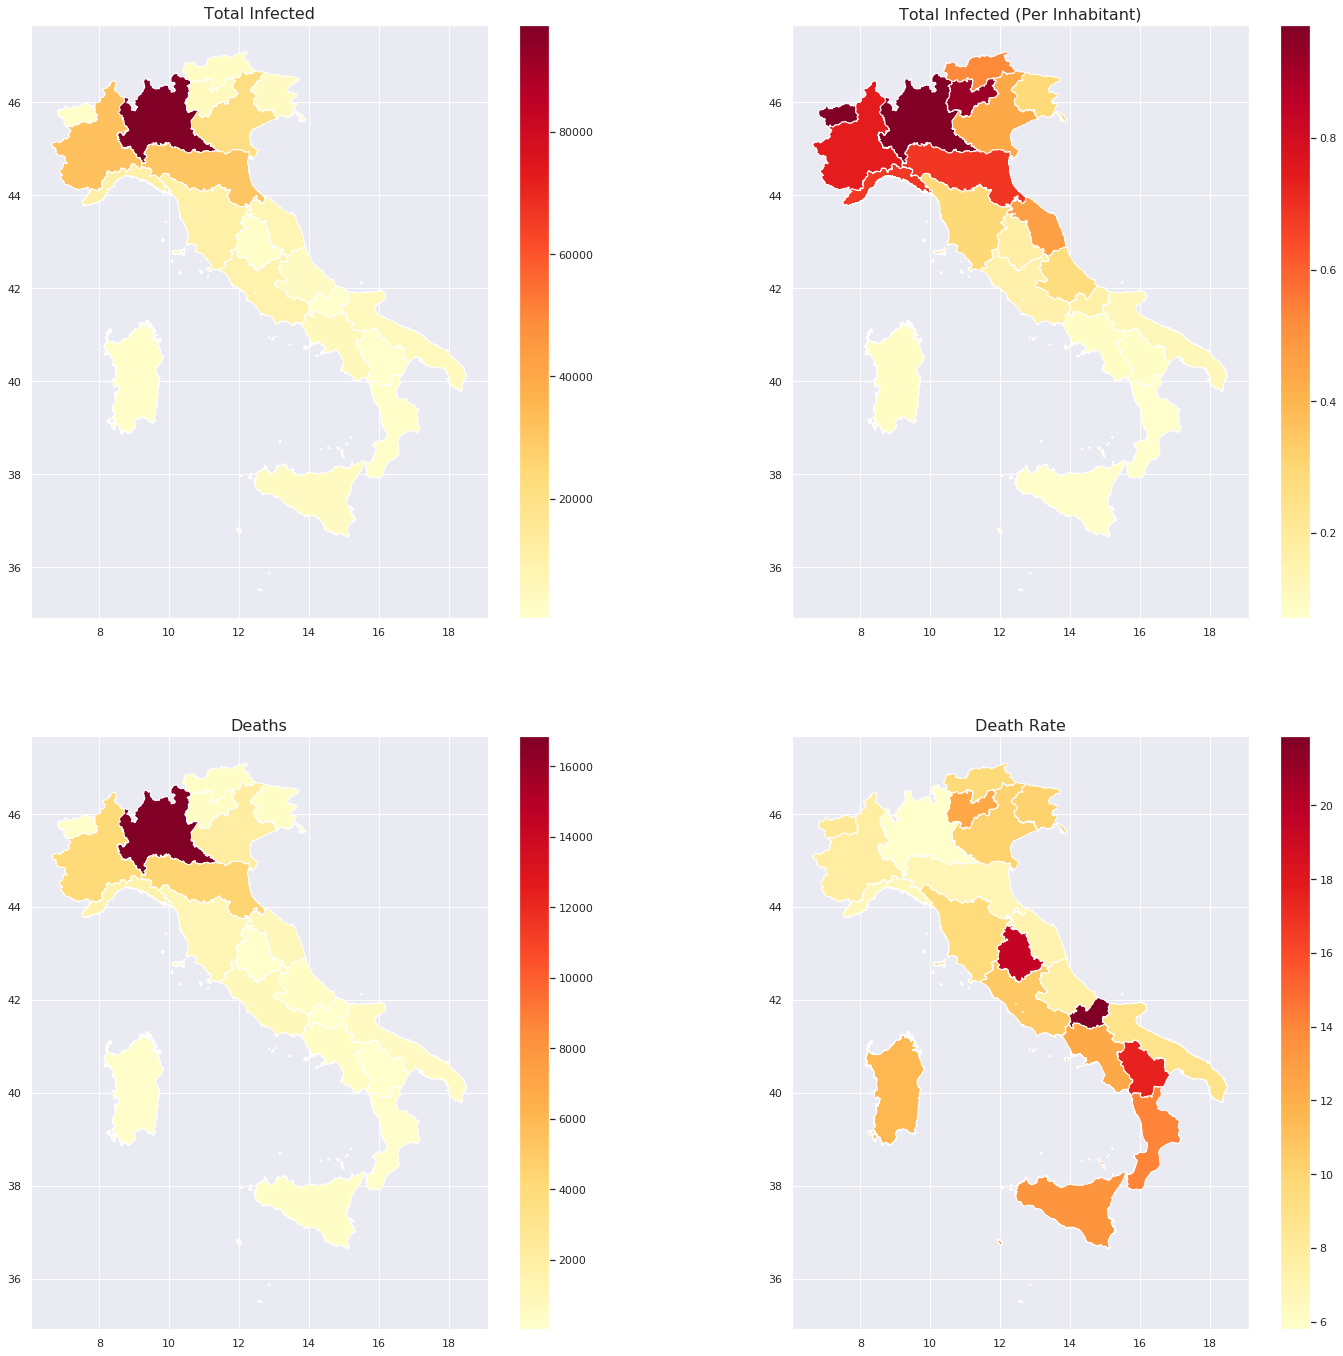

In [300]:
fig, axes = plt.subplots(2, 2, figsize=(25,24))
ax = geo_data_by_region.plot(ax=axes[0, 0], column='totale_casi', cmap="YlOrRd", legend=True)
ax.title.set_text("Total Infected")
ax.title.set_fontsize(16)
ax = geo_data_relative.plot(ax=axes[0, 1], column='totale_casi', cmap="YlOrRd", legend=True)
ax.title.set_text("Total Infected (Per Inhabitant)")
ax.title.set_fontsize(16)
ax = geo_data_by_region.plot(ax=axes[1, 0], column='deceduti', cmap="YlOrRd", legend=True)
ax.title.set_text("Deaths")
ax.title.set_fontsize(16)
ax = geo_data_by_region.plot(ax=axes[1, 1], column='death_rate', cmap="YlOrRd", legend=True)
ax.title.set_text("Death Rate")
ax.title.set_fontsize(16)

From the heatmaps that represent the absolute values, seems that Lombardia was the only region that faced off the emergency of the disease. However, lookin at the data relative to the population (upper-right chart) we can observe that all the north-west regions were affected hard by COIVD-19, with Trento, Valle d'Aosta and Lombardia registering the highest infected per inhabitant.
Furthermore, even if Veneto border on Lombardia and Trento, here a relatively small number of infected per inhabitant was registered. Apparently, they successfully handle the emergency.

Concerning the death rate, surprisingly the southern regions together with Umbria, that have a very small number of positive cases, registered the higher death rates.

Finally, we can compare the absolute and relative number of swab tests and people tested:

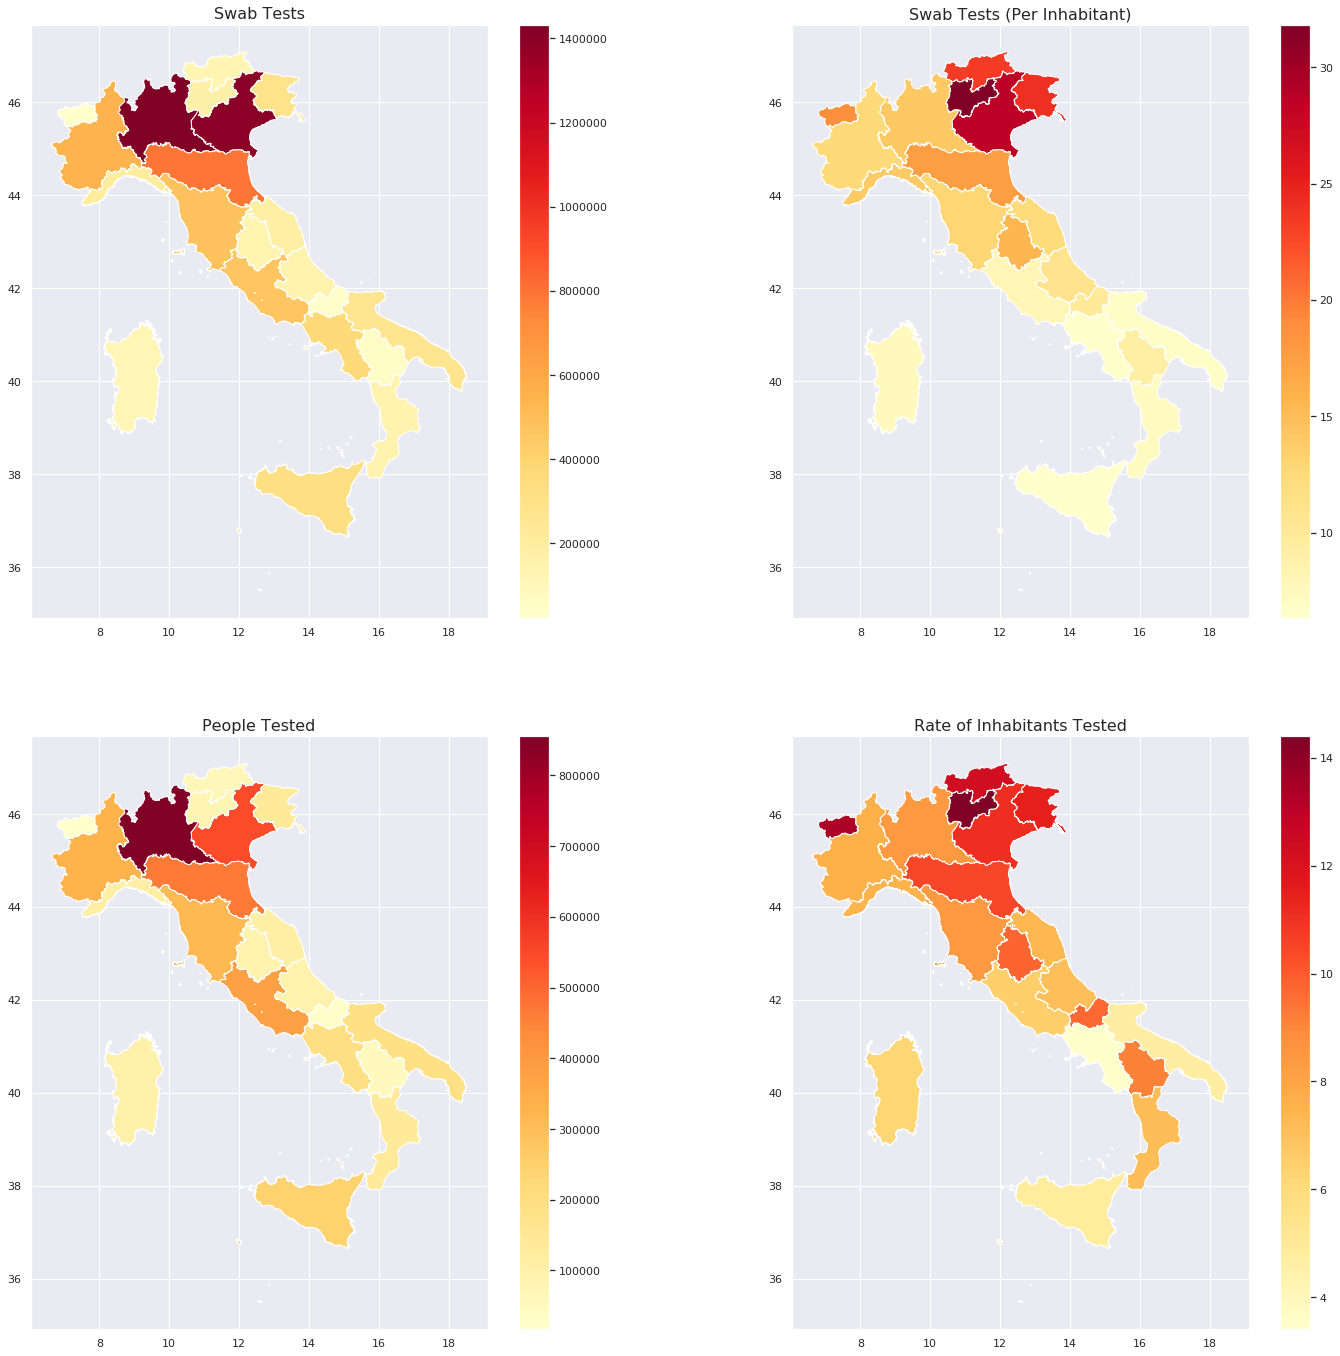

In [301]:
fig, axes = plt.subplots(2, 2, figsize=(25,24))
ax = geo_data_by_region.plot(ax=axes[0, 0], column='tamponi', cmap="YlOrRd", legend=True)
ax.title.set_text("Swab Tests")
ax.title.set_fontsize(16)
ax = geo_data_relative.plot(ax=axes[0, 1], column='tamponi', cmap="YlOrRd", legend=True)
ax.title.set_text("Swab Tests (Per Inhabitant)")
ax.title.set_fontsize(16)
ax = geo_data_by_region.plot(ax=axes[1, 0], column='casi_testati', cmap="YlOrRd", legend=True)
ax.title.set_text("People Tested")
ax.title.set_fontsize(16)
ax = geo_data_relative.plot(ax=axes[1, 1], column='casi_testati', cmap="YlOrRd", legend=True)
ax.title.set_text("Rate of Inhabitants Tested")
ax.title.set_fontsize(16)

Lombardia did a small number of tests compared to its population. Maybe its health facilities were not prepared to face off the emergency.
On the other hand, North-east regions tested a large part of their population. In particular Veneto registered a small number of positive cases per inhabitant and a large rate of inhabitant tested. This suggets that its health facilities and organization were efficient.

Some central and southern regions (Umbria, Molise, Basilicata, Calabria) tested a consistent part of population despite a low number of infected people registered.

---

### Adding geographical information to provinces data

Provinces data contains information about the total cases per province registered until a certain date together with the geographical position of each province (columns `lat` and `long`).
We could combine this data with the geographical information of the provinces to obtain some scatter plots that show the evolution of the infection over time.

Let us try to plot the data relative to a certain date:

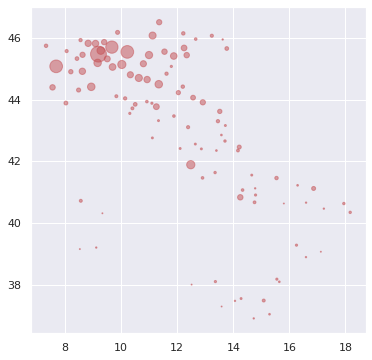

In [302]:
last_day = df_prov.index.max()[0]
source_data = df_prov.loc[last_day]

plt.figure(figsize=(6, 6))
plt.scatter(source_data["long"], source_data["lat"], s=source_data["totale_casi"]//100,
            c="r", alpha=0.5);

It looks like the map of Italy. We could overlap a similar scatterplot to the map of provinces already seen above to observe the distribution of the contagion over the time.

We sample the province data every two weeks, and for simplicity we consider only the period from March to mid-May, when the most of positive cases were registered:

In [303]:
df_prov_monthly = df_prov[:"2020-05-15"].unstack().asfreq("2W").stack()
sampled_dates = df_prov_monthly.index.get_level_values("data").unique()
sampled_dates

DatetimeIndex(['2020-03-01', '2020-03-15', '2020-03-29', '2020-04-12',
               '2020-04-26', '2020-05-10'],
              dtype='datetime64[ns]', name='data', freq=None)

We then create a chart for each sampled date, representing the distribution of the contagion on that date:

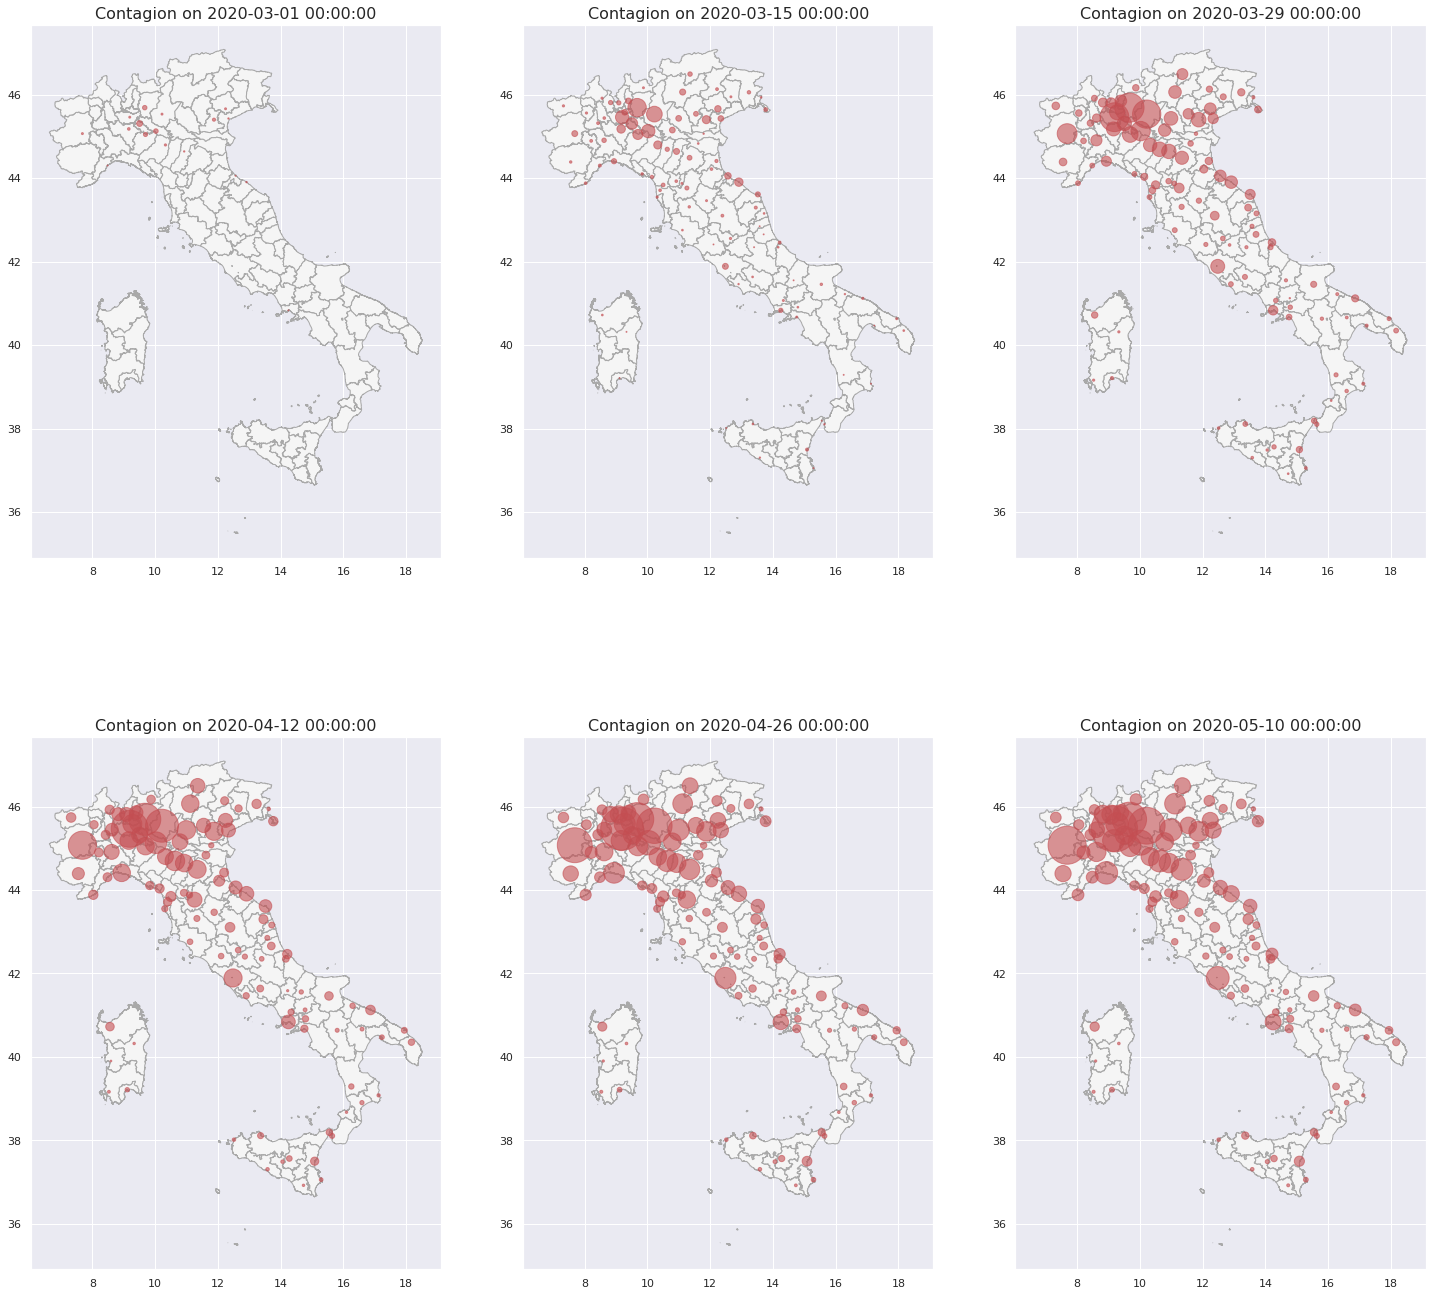

In [304]:
n_rows = math.ceil(len(sampled_dates)/3)
fig, axes = plt.subplots(n_rows, 3, figsize=(25,12*n_rows))

row = 0
column = 0
for i in range(len(sampled_dates)):
    ax = axes[row, column]
    geo_prov.plot(ax=axes[row, column], color = "whitesmoke", edgecolor = "darkgrey")
    plt.axes(ax)
    plt.scatter(df_prov_monthly.loc[sampled_dates[i], ["long"]],
                df_prov_monthly.loc[sampled_dates[i], ["lat"]],
                s=df_prov_monthly.loc[sampled_dates[i],["totale_casi"]]//10, c="r", alpha=0.6);
    ax.set_title("Contagion on " + str(sampled_dates[i]), fontsize=16)
    column += 1
    if column == 3:
        column = 0
        row += 1

The first cases were registered in Lombardia and Emilia-Romagna at the beginning of March, and after two weeks the virus had already significantly spread to all the nearby regions, and cases were starting to be registered all over the country.

At the end of March all the northern and central provinces had already a considerable amount of infected.

Once again, we can observe that the virus affected mainly only the northern and central regions.

---

## 7. Conclusions<a name="section_7"></a>

The data analyzed in this work have a lot of information that allowed us to analyze the evolution of the pandemic crisis in our country. 
Despite the data are comprehensive and well organized, they are not error free. Sometimes we found missing values and little errors, that we fixed in a preprocessing stage.

We first analyzed the data from a national point of view, computing overall statistics and trends. Then we move on the regional data, first focusing on the absolute numbers and then comparing them with the population of each region. Finally, we plot some maps to give an overview of the already seen data.

From our analysis we noted that the epicenter of the epidemic was the northern area, and in particulare the north-west regions. Lombardia had the highest absolute number of infected and deaths, but if we compare the data with the population, all the northern regions were affected about the same way by the contagion.
North-east regions (Veneto and Friuli-Venezia Giulia) did a great work to stem the virus spread. Indeed here we observed a high number of swab tests done and a relatively small number of infected (compared to the nearby areas).
In general, the southern regions were spared by the health emergency.